## Specify variables for the analysis: 
    - Data (mouse, day, sessions)
    - Neuron type: excit, inhibit, or all
    - Current-choice or previous-choice SVM training
        if current-choice, specify epoch of training, the outcome (corr, incorr, all) and strength (easy, medium, hard, all) of trials for training SVM.
        if previous-choice, specify ITI flag
    - Trials that will be used for projections and class accuracy traces (corr, incorr, all, trained).

In [1]:
# Add the option to toggle on/off the raw code. Copied from http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
import sys
if 'ipykernel' in sys.modules:
    from IPython.display import HTML

    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import sys
import os
import numpy as np

# Only run the following section if you are running the code in jupyter, not if on the cluster or in spyder!
if ('ipykernel' in sys.modules and ~any('SPYDER' in name for name in os.environ))==-1:
    
    # Set these variables:
    mousename = 'fni17'
    imagingFolder = '151007'
    mdfFileNumber = [1] 

    roundi = 2; # For the same dataset we run the code multiple times, each time we select a random subset of neurons (of size n, n=.95*numTrials)
    trialHistAnalysis = 0;    

    iTiFlg = 2; # Only needed if trialHistAnalysis=1; short ITI, 1: long ITI, 2: all ITIs.
    numSamples = 2 #100; # number of iterations for finding the best c (inverse of regularization parameter)
    neuronType = 2; # 0: excitatory, 1: inhibitory, 2: all types.    
    saveResults = 0; # save results in mat file.




    # The following vars don't usually need to be changed
    setNsExcluded = 0; # if 1, NsExcluded will be set even if it is already saved.
    doPlots = 1; # Whether to make plots or not.
    saveHTML = 0; # whether to save the html file of notebook with all figures or not.

    if trialHistAnalysis==1: # more parameters are specified in popClassifier_trialHistory.m
    #        iTiFlg = 1; # 0: short ITI, 1: long ITI, 2: all ITIs.
        epEnd_rel2stimon_fr = 0 # 3; # -2 # epEnd = eventI + epEnd_rel2stimon_fr
    else:
        # not needed to set ep_ms here, later you define it as [choiceTime-300 choiceTime]ms # we also go 30ms back to make sure we are not right on the choice time!
        ep_ms = [809, 1109] #[425, 725] # optional, it will be set according to min choice time if not provided.# training epoch relative to stimOnset % we want to decode animal's upcoming choice by traninig SVM for neural average responses during ep ms after stimulus onset. [1000, 1300]; #[700, 900]; # [500, 700]; 
        # outcome2ana will be used if trialHistAnalysis is 0. When it is 1, by default we are analyzing past correct trials. If you want to change that, set it in the matlab code.
        outcome2ana = 'corr' # '', corr', 'incorr' # trials to use for SVM training (all, correct or incorrect trials)
        strength2ana = 'all' # 'all', easy', 'medium', 'hard' % What stim strength to use for training?
        thStimStrength = 3; # 2; # threshold of stim strength for defining hard, medium and easy trials.
        th_stim_dur = 800; # min stim duration to include a trial in timeStimOnset

    trs4project = 'trained' # 'trained', 'all', 'corr', 'incorr' # trials that will be used for projections and the class accuracy trace; if 'trained', same trials that were used for SVM training will be used. "corr" and "incorr" refer to current trial's outcome, so they don't mean much if trialHistAnalysis=1. 
    windowAvgFlg = 1 # if 0, data points during ep wont be averaged when setting X (for SVM training), instead each frame of ep will be treated as a separate datapoint. It helps with increasing number of datapoints, but will make data mor enoisy.

    thAct = 5e-4 #5e-4; # 1e-5 # neurons whose average activity during ep is less than thAct will be called non-active and will be excluded.
    thTrsWithSpike = 1; # 3 % remove neurons that are active in <thSpTr trials.

    pnev2load = [] #[] [3] # which pnev file to load: indicates index of date-sorted files: use 0 for latest. Set [] to load the latest one.


In [4]:
if neuronType==0:
    ntName = 'excit'
elif neuronType==1:
    ntName = 'inhibit'
elif neuronType==2:
    ntName = 'all'     

if trialHistAnalysis==1:    
    if iTiFlg==0:
        itiName = 'short'
    elif iTiFlg==1:
        itiName = 'long'
    elif iTiFlg==2:
        itiName = 'all'        
    
print 'Analyzing %s' %(mousename+'_'+imagingFolder+'_'+str(mdfFileNumber)) 
if trialHistAnalysis==0:
    print 'Training %s trials of strength %s. Making projections for %s trials' %(outcome2ana, strength2ana, trs4project)
print 'trialHistAnalysis = %i' %(trialHistAnalysis)
print 'Analyzing %s neurons' %(ntName)
if trialHistAnalysis==1:
    print 'Analyzing %s ITIs' %(itiName)
elif 'ep_ms' in locals():
    print 'training window: [%d %d] ms' %(ep_ms[0], ep_ms[1])
print 'windowAvgFlg = %i' %(windowAvgFlg)
print 'numSamples = %i' %(numSamples)

Analyzing fni17_151007_[1]
Training corr trials of strength all. Making projections for trained trials
trialHistAnalysis = 0
Analyzing all neurons
training window: [809 1109] ms
windowAvgFlg = 1
numSamples = 2


## Import Libraries and Modules

In [5]:
import scipy.io as scio
import scipy as sci
import scipy.stats as stats
import numpy as np
import numpy.random as rng
import sys
from crossValidateModel import crossValidateModel
from linearSVM import linearSVM
from compiler.ast import flatten
import matplotlib 
from matplotlib import pyplot as plt
if 'ipykernel' in sys.modules and doPlots:
    %matplotlib inline  
    %config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (6,4) #(8,5)
from IPython.display import display
import sklearn.svm as svm
import os
import glob

# print sys.path
sys.path.append('/home/farznaj/Documents/trial_history/imaging') # Gamal's dir needs to be added using "if" that takes the value of pwd
# print sys.path

/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: The compiler package is deprecated and removed in Python 3.x.


In [7]:
# Extend the built in two tailed ttest function to one-tailed
def ttest2(a, b, **tailOption):
    import scipy.stats as stats
    import numpy as np
    h, p = stats.ttest_ind(a, b)
    d = np.mean(a)-np.mean(b)
    if tailOption.get('tail'):
        tail = tailOption.get('tail').lower()
        if tail == 'right':
            p = p/2.*(d>0) + (1-p/2.)*(d<0)
        elif tail == 'left':
            p = (1-p/2.)*(d>0) + p/2.*(d<0)
    if d==0:
        p = 1;
    return p

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 24 15:59:12 2016

@author: farznaj

This is Farzaneh's first Python code :-) She is very happy and pleased about it :D

example call:

mousename = 'fni17'
imagingFolder = '151021'
mdfFileNumber = [1] #(1,2)

# optional inputs:
postNProvided = 1; # Default:0; If your directory does not contain pnevFile and instead it contains postFile, set this to 1 to get pnevFileName
signalCh = [2] # since gcamp is channel 2, should be 2.
pnev2load = [] # which pnev file to load: indicates index of date-sorted files: use 0 for latest. Set [] to load the latest one.

from setImagingAnalysisNamesP import *

imfilename, pnevFileName = setImagingAnalysisNamesP(mousename, imagingFolder, mdfFileNumber, signalCh=signalCh, pnev2load=pnev2load, postNProvided=postNProvided)

imfilename, pnevFileName = setImagingAnalysisNamesP(mousename, imagingFolder, mdfFileNumber)

"""

#%%
def setImagingAnalysisNamesP(mousename, imagingFolder, mdfFileNumber, **options):

    if options.get('signalCh'):
        signalCh = options.get('signalCh');    
    else:
        signalCh = []
        
    if options.get('pnev2load'):
        pnev2load = options.get('pnev2load');    
    else:
        pnev2load = []
        
    if options.get('postNProvided'):
        postNProvided = options.get('postNProvided');    
    else:
        postNProvided = 0
        
    #%%
    import numpy as np
    import platform
    import glob
    import os.path
        
    if len(pnev2load)==0:
        pnev2load = [0];
            
    #%%
    dataPath = []
    if platform.system()=='Linux':
        if os.getcwd().find('sonas')==1: # server
            dataPath = '/sonas-hs/churchland/nlsas/data/data/'
        else: # office linux
            dataPath = '/home/farznaj/Shares/Churchland/data/'
    else:
        dataPath = '/Users/gamalamin/git_local_repository/Farzaneh/data/'
        
    #%%        
    tifFold = os.path.join(dataPath+mousename,'imaging',imagingFolder)
    r = '%03d-'*len(mdfFileNumber)
    r = r[:-1]
    rr = r % (tuple(mdfFileNumber))
    
    date_major = imagingFolder+'_'+rr
    imfilename = os.path.join(tifFold,date_major+'.mat')
    
    #%%
    if len(signalCh)>0:
        if postNProvided:
            pnevFileName = 'post_'+date_major+'_ch'+str(signalCh)+'-Pnev*'
        else:
            pnevFileName = date_major+'_ch'+str(signalCh)+'-Pnev*'
            
        pnevFileName = glob.glob(os.path.join(tifFold,pnevFileName))   
        # sort pnevFileNames by date (descending)
        pnevFileName = sorted(pnevFileName, key=os.path.getmtime)
        pnevFileName = pnevFileName[::-1]
        '''
        array = []
        for idx in range(0, len(pnevFileName)):
            array.append(os.path.getmtime(pnevFileName[idx]))

        inds = np.argsort(array)
        inds = inds[::-1]
        pnev2load = inds[pnev2load]
        '''    
        if len(pnevFileName)==0:
            c = ("No Pnev file was found"); print("%s\n" % c)
            pnevFileName = ''
        else:
            pnevFileName = pnevFileName[pnev2load[0]]
            if postNProvided:
                p = os.path.basename(pnevFileName)[5:]
                pnevFileName = os.path.join(tifFold,p)
    else:
        pnevFileName = ''
    
    #%%
    return imfilename, pnevFileName
    
    
#%%
#imfilename, pnevFileName = setImagingAnalysisNamesP(mousename, imagingFolder, mdfFileNumber, signalCh, pnev2load)



## Set mat-file names

In [9]:
pnev2load = [] #[] [3] # which pnev file to load: indicates index of date-sorted files: use 0 for latest. Set [] to load the latest one.
signalCh = [2] # since gcamp is channel 2, should be always 2.
postNProvided = 1; # If your directory does not contain pnevFile and instead it contains postFile, set this to 1 to get pnevFileName

# from setImagingAnalysisNamesP import *

imfilename, pnevFileName = setImagingAnalysisNamesP(mousename, imagingFolder, mdfFileNumber, signalCh=signalCh, pnev2load=pnev2load, postNProvided=postNProvided)

postName = os.path.join(os.path.dirname(pnevFileName), 'post_'+os.path.basename(pnevFileName))
moreName = os.path.join(os.path.dirname(pnevFileName), 'more_'+os.path.basename(pnevFileName))

print(imfilename)
print(pnevFileName)
print(postName)
print(moreName)


/home/farznaj/Shares/Churchland/data/fni17/imaging/151007/151007_001.mat
/home/farznaj/Shares/Churchland/data/fni17/imaging/151007/151007_001_ch2-PnevPanResults-161024-161316.mat
/home/farznaj/Shares/Churchland/data/fni17/imaging/151007/post_151007_001_ch2-PnevPanResults-161024-161316.mat
/home/farznaj/Shares/Churchland/data/fni17/imaging/151007/more_151007_001_ch2-PnevPanResults-161024-161316.mat


## Load matlab variables: event-aligned traces, inhibitRois, outcomes,  choice, etc
    - traces are set in set_aligned_traces.m matlab script.

In [10]:
# Set traces_al_stim that is same as traces_al_stimAll except that in traces_al_stim some trials are set to nan, bc their stim duration is < 
# th_stim_dur or bc their go tone happens before ep(end) or bc their choice happened before ep(end). 
# But in traces_al_stimAll, all trials are included. 
# You need traces_al_stim for decoding the upcoming choice bc you average responses during ep and you want to 
# control for what happens there. But for trial-history analysis you average responses before stimOnset, so you 
# don't care about when go tone happened or how long the stimulus was. 

frameLength = 1000/30.9; # sec.
    
# Load time of some trial events    
Data = scio.loadmat(postName, variable_names=['timeCommitCL_CR_Gotone', 'timeStimOnset', 'timeStimOffset', 'time1stSideTry'])
timeCommitCL_CR_Gotone = np.array(Data.pop('timeCommitCL_CR_Gotone')).flatten().astype('float')
timeStimOnset = np.array(Data.pop('timeStimOnset')).flatten().astype('float')
timeStimOffset = np.array(Data.pop('timeStimOffset')).flatten().astype('float')
time1stSideTry = np.array(Data.pop('time1stSideTry')).flatten().astype('float')


# Load stim-aligned_allTrials traces, frames, frame of event of interest
if trialHistAnalysis==0:
    Data = scio.loadmat(postName, variable_names=['stimAl_noEarlyDec'],squeeze_me=True,struct_as_record=False)
    eventI = Data['stimAl_noEarlyDec'].eventI - 1 # remember difference indexing in matlab and python!
    traces_al_stimAll = Data['stimAl_noEarlyDec'].traces.astype('float')
    time_aligned_stim = Data['stimAl_noEarlyDec'].time.astype('float')

else:
    Data = scio.loadmat(postName, variable_names=['stimAl_allTrs'],squeeze_me=True,struct_as_record=False)
    eventI = Data['stimAl_allTrs'].eventI - 1 # remember difference indexing in matlab and python!
    traces_al_stimAll = Data['stimAl_allTrs'].traces.astype('float')
    time_aligned_stim = Data['stimAl_allTrs'].time.astype('float')
    # time_aligned_stimAll = Data['stimAl_allTrs'].time.astype('float') # same as time_aligned_stim

print 'size of stimulus-aligned traces:', np.shape(traces_al_stimAll), '(frames x units x trials)'
DataS = Data



# Load outcomes and choice (allResp_HR_LR) for the current trial
# if trialHistAnalysis==0:
Data = scio.loadmat(postName, variable_names=['outcomes', 'allResp_HR_LR'])
outcomes = (Data.pop('outcomes').astype('float'))[0,:]
# allResp_HR_LR = (Data.pop('allResp_HR_LR').astype('float'))[0,:]
allResp_HR_LR = np.array(Data.pop('allResp_HR_LR')).flatten().astype('float')
choiceVecAll = allResp_HR_LR+0;  # trials x 1;  1 for HR choice, 0 for LR choice. % choice of the current trial.    
# choiceVecAll = np.transpose(allResp_HR_LR);  # trials x 1;  1 for HR choice, 0 for LR choice. % choice of the current trial.    
print 'Current outcome: %d correct choices; %d incorrect choices' %(sum(outcomes==1), sum(outcomes==0))


if trialHistAnalysis:
    # Load trialHistory structure to get choice vector of the previous trial
    Data = scio.loadmat(postName, variable_names=['trialHistory'],squeeze_me=True,struct_as_record=False)
    choiceVec0All = Data['trialHistory'].choiceVec0.astype('float')


    
# Set trials strength and identify trials with stim strength of interest
if trialHistAnalysis==0:
    Data = scio.loadmat(postName, variable_names=['stimrate', 'cb'])
    stimrate = np.array(Data.pop('stimrate')).flatten().astype('float')
    cb = np.array(Data.pop('cb')).flatten().astype('float')

    s = stimrate-cb; # how far is the stimulus rate from the category boundary?
    if strength2ana == 'easy':
        str2ana = (abs(s) >= (max(abs(s)) - thStimStrength));
    elif strength2ana == 'hard':
        str2ana = (abs(s) <= thStimStrength);
    elif strength2ana == 'medium':
        str2ana = ((abs(s) > thStimStrength) & (abs(s) < (max(abs(s)) - thStimStrength))); 
    else:
        str2ana = np.full((1, np.shape(outcomes)[0]), True, dtype=bool).flatten();

    print 'Number of trials with stim strength of interest = %i' %(str2ana.sum())
    print 'Stim rates for training = {}'.format(np.unique(stimrate[str2ana]))

    '''
    # Set to nan those trials in outcomes and allRes that are nan in traces_al_stim
    I = (np.argwhere((~np.isnan(traces_al_stim).sum(axis=0)).sum(axis=1)))[0][0] # first non-nan neuron
    allTrs2rmv = np.argwhere(sum(np.isnan(traces_al_stim[:,I,:])))
    print(np.shape(allTrs2rmv))

    outcomes[allTrs2rmv] = np.nan
    allResp_HR_LR[allTrs2rmv] = np.nan
    '''

size of stimulus-aligned traces: (73, 563, 302) (frames x units x trials)
Current outcome: 241 correct choices; 46 incorrect choices
Number of trials with stim strength of interest = 302
Stim rates for training = [  6.   7.   8.   9.  10.  11.  12.  15.  16.  17.  18.  19.  20.  21.  22.
  23.  24.  25.  26.  27.]


## Set the time window for training SVM (ep) and traces_al_stim

Training epoch relative to stimOnset is [  793.   825.   858.   890.   922.   955.   987.  1019.  1052.  1084.
  1117.] ms
No trials with choice before the end of ep. Good :)


/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in less_equal
/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in less


No trials with stimDur < 800ms. Good :)
Not excluding 241 trials whose goTone is earlier than ep end
Final: 0 trials excluded in traces_al_stim


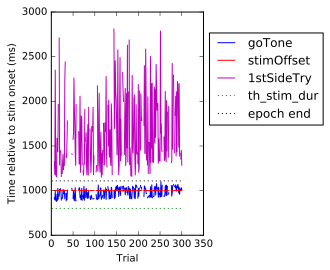

In [11]:
traces_al_stim = traces_al_stimAll

if trialHistAnalysis==1:    
    # either of the two below (stimulus-aligned and initTone-aligned) would be fine
    # eventI = DataI['initToneAl'].eventI - 1
    eventI = DataS['stimAl_allTrs'].eventI - 1 # remember to subtract 1! matlab vs python indexing!   
    epEnd = eventI + epEnd_rel2stimon_fr #- 2 # to be safe for decoder training for trial-history analysis we go upto the frame before the stim onset
    # epEnd = DataI['initToneAl'].eventI - 2 # to be safe for decoder training for trial-history analysis we go upto the frame before the initTone onset
    ep = np.arange(epEnd+1)
    print 'training epoch is {} ms'.format(np.round((ep-eventI)*frameLength))
    
    ep_ms = list(np.round((ep[[0,-1]]-eventI)*frameLength).astype(int)) # so it is the same format as ep_ms when trialHistAnalysis is 0
    
else:
    # Set ep_ms if it is not provided: [choiceTime-300 choiceTime]ms # we also go 30ms back to make sure we are not right on the choice time!
    # by doing this you wont need to set ii below.
    
    # We first set to nan timeStimOnset of trials that anyway wont matter bc their outcome is  not of interest. we do this to make sure these trials dont affect our estimate of ep_ms
    if outcome2ana == 'corr':
        timeStimOnset[outcomes!=1] = np.nan; # analyze only correct trials.
    elif outcome2ana == 'incorr':
        timeStimOnset[outcomes!=0] = np.nan; # analyze only incorrect trials.   
        
    if not 'ep_ms' in locals(): 
        ep_ms = [np.floor(np.nanmin(time1stSideTry-timeStimOnset))-30-300, np.floor(np.nanmin(time1stSideTry-timeStimOnset))-30]
        print 'Training window: [%d %d] ms' %(ep_ms[0], ep_ms[1])
    
    epStartRel2Event = np.ceil(ep_ms[0]/frameLength); # the start point of the epoch relative to alignedEvent for training SVM. (500ms)
    epEndRel2Event = np.ceil(ep_ms[1]/frameLength); # the end point of the epoch relative to alignedEvent for training SVM. (700ms)
    ep = np.arange(eventI+epStartRel2Event, eventI+epEndRel2Event+1).astype(int); # frames on stimAl.traces that will be used for trainning SVM.   
    print 'Training epoch relative to stimOnset is {} ms'.format(np.round((ep-eventI)*frameLength - frameLength/2)) # print center of frames in ms
            
        
    #%% Exclude some trials from traces_al_stim
    # This criteria makes sense if you want to be conservative; otherwise if ep=[1000 1300]ms, go tone will definitely be before ep end, and you cannot have the following criteria.
    # Make sure in none of the trials Go-tone happened before the end of training window (ep)
    i = (timeCommitCL_CR_Gotone - timeStimOnset) <= ep_ms[-1];
    '''
    if np.sum(i)>0:
        print 'Excluding %i trials from timeStimOnset bc their goTone is earlier than ep end' %(np.sum(i))
    #     timeStimOnset[i] = np.nan;  # by setting to nan, the aligned-traces of these trials will be computed as nan.
    else:
        print('No trials with go tone before the end of ep. Good :)')
    '''
        
    # Make sure in none of the trials choice (1st side try) happened before the end of training window (ep)
    ii = (time1stSideTry - timeStimOnset) <= ep_ms[-1];
    if np.sum(ii)>0:
        print 'Excluding %i trials from timeStimOnset bc their choice is earlier than ep end' %(np.sum(ii))
    #     timeStimOnset[i] = np.nan;  # by setting to nan, the aligned-traces of these trials will be computed as nan.
    else:
        print('No trials with choice before the end of ep. Good :)')        


    # Make sure trials that you use for SVM (decoding upcoming choice from
    # neural responses during stimulus) have a certain stimulus duration. Of
    # course stimulus at least needs to continue until the end of ep. 
    # go with either 900 or 800ms. Since the preference is to have at least
    # ~100ms after ep which contains stimulus and without any go tones, go with 800ms
    # bc in many sessions go tone happened early... so you will loose lots of
    # trials if you go with 900ms.
    # th_stim_dur = 800; # min stim duration to include a trial in timeStimOnset

    if doPlots:
        plt.figure
        plt.subplot(1,2,1)
        plt.plot(timeCommitCL_CR_Gotone - timeStimOnset, label = 'goTone')
        plt.plot(timeStimOffset - timeStimOnset, 'r', label = 'stimOffset')
        plt.plot(time1stSideTry - timeStimOnset, 'm', label = '1stSideTry')
        plt.plot([1, np.shape(timeCommitCL_CR_Gotone)[0]],[th_stim_dur, th_stim_dur], 'g:', label = 'th_stim_dur')
        plt.plot([1, np.shape(timeCommitCL_CR_Gotone)[0]],[ep_ms[-1], ep_ms[-1]], 'k:', label = 'epoch end')
        plt.xlabel('Trial')
        plt.ylabel('Time relative to stim onset (ms)')
        plt.legend(loc='center left', bbox_to_anchor=(1, .7)) 
        # minStimDurNoGoTone = np.nanmin(timeCommitCL_CR_Gotone - timeStimOnset); # this is the duration after stim onset during which no go tone occurred for any of the trials.
        # print 'minStimDurNoGoTone = %.2f ms' %minStimDurNoGoTone


    # Exclude trials whose stim duration was < th_stim_dur
    j = (timeStimOffset - timeStimOnset) < th_stim_dur;
    if np.sum(j)>0:
        print 'Excluding %i trials from timeStimOnset bc their stimDur < %dms' %(np.sum(j), th_stim_dur)
    #     timeStimOnset[j] = np.nan;
    else:
        print 'No trials with stimDur < %dms. Good :)' %th_stim_dur



    # Set trials to be removed from traces_al_stimAll    
    # toRmv = (i+j+ii)!=0;  
    toRmv = (j+ii)!=0; print 'Not excluding %i trials whose goTone is earlier than ep end' %sum(i)
    print 'Final: %i trials excluded in traces_al_stim' %np.sum(toRmv)

    
    # Set traces_al_stim for SVM classification of current choice.     
    traces_al_stim[:,:,toRmv] = np.nan
#     traces_al_stim[:,:,outcomes==-1] = np.nan
    # print(np.shape(traces_al_stim))


    '''
    # Set ep
    if len(ep_ms)==0: # load ep from matlab
        # Load stimulus-aligned traces, frames, frame of event of interest, and epoch over which we will average the responses to do SVM analysis
        Data = scio.loadmat(postName, variable_names=['stimAl'],squeeze_me=True,struct_as_record=False)
        # eventI = Data['stimAl'].eventI - 1 # remember difference indexing in matlab and python!
        # traces_al_stim = Data['stimAl'].traces.astype('float') # traces_al_stim
        # time_aligned_stim = Data['stimAl'].time.astype('float')

        ep = Data['stimAl'].ep - 1
        ep_ms = np.round((ep-eventI)*frameLength).astype(int)
        
    else: # set ep here:
    '''        

In [12]:
# Load 1stSideTry-aligned traces, frames, frame of event of interest
# use firstSideTryAl_COM to look at changes-of-mind (mouse made a side lick without committing it)
Data = scio.loadmat(postName, variable_names=['firstSideTryAl'],squeeze_me=True,struct_as_record=False)
traces_al_1stSide = Data['firstSideTryAl'].traces.astype('float')
time_aligned_1stSide = Data['firstSideTryAl'].time.astype('float')
# print(np.shape(traces_al_1stSide))


# Load goTone-aligned traces, frames, frame of event of interest
# use goToneAl_noStimAft to make sure there was no stim after go tone.
Data = scio.loadmat(postName, variable_names=['goToneAl'],squeeze_me=True,struct_as_record=False)
traces_al_go = Data['goToneAl'].traces.astype('float')
time_aligned_go = Data['goToneAl'].time.astype('float')
# print(np.shape(traces_al_go))


# Load reward-aligned traces, frames, frame of event of interest
Data = scio.loadmat(postName, variable_names=['rewardAl'],squeeze_me=True,struct_as_record=False)
traces_al_rew = Data['rewardAl'].traces.astype('float')
time_aligned_rew = Data['rewardAl'].time.astype('float')
# print(np.shape(traces_al_rew))


# Load commitIncorrect-aligned traces, frames, frame of event of interest
Data = scio.loadmat(postName, variable_names=['commitIncorrAl'],squeeze_me=True,struct_as_record=False)
traces_al_incorrResp = Data['commitIncorrAl'].traces.astype('float')
time_aligned_incorrResp = Data['commitIncorrAl'].time.astype('float')
# print(np.shape(traces_al_incorrResp))


# Load initiationTone-aligned traces, frames, frame of event of interest
Data = scio.loadmat(postName, variable_names=['initToneAl'],squeeze_me=True,struct_as_record=False)
traces_al_init = Data['initToneAl'].traces.astype('float')
time_aligned_init = Data['initToneAl'].time.astype('float')
# print(np.shape(traces_al_init))
# DataI = Data
'''
if trialHistAnalysis:
    # either of the two below (stimulus-aligned and initTone-aligned) would be fine
    # eventI = DataI['initToneAl'].eventI
    eventI = DataS['stimAl_allTrs'].eventI    
    epEnd = eventI + epEnd_rel2stimon_fr #- 2 # to be safe for decoder training for trial-history analysis we go upto the frame before the stim onset
    # epEnd = DataI['initToneAl'].eventI - 2 # to be safe for decoder training for trial-history analysis we go upto the frame before the initTone onset
    ep = np.arange(epEnd+1)
    print 'training epoch is {} ms'.format(np.round((ep-eventI)*frameLength))
'''
    

# Load inhibitRois
Data = scio.loadmat(moreName, variable_names=['inhibitRois'])
inhibitRois = Data.pop('inhibitRois')[0,:]
# print '%d inhibitory, %d excitatory; %d unsure class' %(np.sum(inhibitRois==1), np.sum(inhibitRois==0), np.sum(np.isnan(inhibitRois)))

    
# Set traces for specific neuron types: inhibitory, excitatory or all neurons
if neuronType!=2:    
    nt = (inhibitRois==neuronType) # 0: excitatory, 1: inhibitory, 2: all types.
    # good_excit = inhibitRois==0;
    # good_inhibit = inhibitRois==1;        
    
    traces_al_stim = traces_al_stim[:, nt, :];
    traces_al_1stSide = traces_al_1stSide[:, nt, :];
    traces_al_go = traces_al_go[:, nt, :];
    traces_al_rew = traces_al_rew[:, nt, :];
    traces_al_incorrResp = traces_al_incorrResp[:, nt, :];
    traces_al_init = traces_al_init[:, nt, :];
    traces_al_stimAll = traces_al_stimAll[:, nt, :];
else:
    nt = np.arange(np.shape(traces_al_1stSide)[1])    


## Set X (trials x neurons) and Y (trials x 1) for training the SVM classifier.
    X matrix (size trials x neurons) that contains neural responses at different trials.
    Y choice of high rate (modeled as 1) and low rate (modeled as 0)

In [13]:
# Set choiceVec0  (Y: the response vector)

if trialHistAnalysis:
    choiceVec0 = choiceVec0All[:,iTiFlg] # choice on the previous trial for short (or long or all) ITIs
    choiceVec0S = choiceVec0All[:,0]
    choiceVec0L = choiceVec0All[:,1]
else: # set choice for the current trial
    choiceVec0 = allResp_HR_LR;  # trials x 1;  1 for HR choice, 0 for LR choice. % choice of the current trial.    
    # choiceVec0 = np.transpose(allResp_HR_LR);  # trials x 1;  1 for HR choice, 0 for LR choice. % choice of the current trial.    
    if outcome2ana == 'corr':
        choiceVec0[outcomes!=1] = np.nan; # analyze only correct trials.
    elif outcome2ana == 'incorr':
        choiceVec0[outcomes!=0] = np.nan; # analyze only incorrect trials.   
    
    choiceVec0[~str2ana] = np.nan   
    # Y = choiceVec0
    # print(choiceVec0.shape)


# Set spikeAveEp0  (X: the predictor matrix (trials x neurons) that shows average of spikes for a particular epoch for each trial and neuron.)

if trialHistAnalysis:
    # either of the two cases below should be fine (init-aligned traces or stim-aligned traces.)
    spikeAveEp0 = np.transpose(np.nanmean(traces_al_stimAll[ep,:,:], axis=0)) # trials x neurons    
    # spikeAveEp0 = np.transpose(np.nanmean(traces_al_init[ep,:,:], axis=0)) # trials x neurons    
else:    
    spikeAveEp0 = np.transpose(np.nanmean(traces_al_stim[ep,:,:], axis=0)) # trials x neurons    

# X = spikeAveEp0;
print 'Size of spikeAveEp0 (trs x neurons): ', spikeAveEp0.shape


Size of spikeAveEp0 (trs x neurons):  (302, 563)


/home/farznaj/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [14]:
# set trsExcluded and exclude them to set X and Y; trsExcluded are trials that are nan either in traces or in choice vector.

'''
#dirName = 'SVM_151102_001-002_ch2-PnevPanResults-160624-113108';
dirName = 'SVM_151029_003_ch2-PnevPanResults-160426-191859';
#dirName = '/home/farznaj/Shares/Churchland/data/fni17/imaging/151022/XY_fni17_151022 XY_lassoSVM.mat';
Data = scio.loadmat(dirName, variable_names=['X', 'Y', 'time_aligned_stim', 'non_filtered', 'traces_al_1stSideTry', 'time_aligned_stim_1stSideTry']);
X = Data.pop('X').astype('float')
Y = np.squeeze(Data.pop('Y')).astype('int')
time_aligned_stim = np.squeeze(Data.pop('time_aligned_stim')).astype('float')
Xt = Data.pop('non_filtered').astype('float')
Xt_choiceAl = Data.pop('traces_al_1stSideTry').astype('float')
time_aligned_1stSide = np.squeeze(Data.pop('time_aligned_stim_1stSideTry')).astype('float')
'''

# Identify nan trials
trsExcluded = (np.sum(np.isnan(spikeAveEp0), axis = 1) + np.isnan(choiceVec0)) != 0 # NaN trials # trsExcluded
# print sum(trsExcluded), 'NaN trials'

# Exclude nan trials
X = spikeAveEp0[~trsExcluded,:]; # trials x neurons
Y = choiceVec0[~trsExcluded];
print '%d high-rate choices, and %d low-rate choices\n' %(np.sum(Y==1), np.sum(Y==0))


114 high-rate choices, and 127 low-rate choices



In [15]:
# Set NsExcluded : Identify neurons that did not fire in any of the trials (during ep) and then exclude them. Otherwise they cause problem for feature normalization.
# thAct and thTrsWithSpike are parameters that you can play with.

# If it is already saved, load it (the idea is to use the same NsExcluded for all the analyses of a session). Otherwise set it.
if trialHistAnalysis==0:
    svmnowname = 'svmCurrChoice_allN' + '_*-' + pnevFileName[-32:]
else:
    svmnowname = 'svmPrevChoice_allN_allITIs' + '_*-' + pnevFileName[-32:]
svmName = glob.glob(os.path.join(os.path.dirname(pnevFileName), 'svm', svmnowname))
svmName = sorted(svmName, key=os.path.getmtime)[::-1] # so the latest file is the 1st one.
    

if setNsExcluded==0 and np.shape(svmName)[0]!=0: # NsExcluded is already set and saved # 0: #    
    svmName = svmName[0]  # get the latest file
    print 'loading NsExcluded from file', svmName    
    Data = scio.loadmat(svmName, variable_names=['NsExcluded'])
    NsExcluded = Data.pop('NsExcluded')[0,:].astype('bool')
    NsExcluded = NsExcluded[nt]      

    stdX = np.std(X, axis = 0); # define stdX for all neurons; later we reset it only including active neurons
    if min(stdX[~NsExcluded]) < thAct: # make sure the loaded NsExcluded makes sense; ie stdX of ~NsExcluded is above thAct
        sys.exit(('min of stdX= %.8f; not supposed to be <%d (thAct)!'  %(min(stdX), thAct)))
else:
    
    print 'NsExcluded not saved, so setting it here'
    
    if trialHistAnalysis and iTiFlg!=2:
        # set X for short-ITI and long-ITI cases (XS,XL).
        trsExcludedS = (np.sum(np.isnan(spikeAveEp0), axis = 1) + np.isnan(choiceVec0S)) != 0 
        XS = spikeAveEp0[~trsExcludedS,:]; # trials x neurons
        trsExcludedL = (np.sum(np.isnan(spikeAveEp0), axis = 1) + np.isnan(choiceVec0L)) != 0 
        XL = spikeAveEp0[~trsExcludedL,:]; # trials x neurons

        # Define NsExcluded as neurons with low stdX for either short ITI or long ITI trials. 
        # This is to make sure short and long ITI cases will include the same set of neurons.
        stdXS = np.std(XS, axis = 0);
        stdXL = np.std(XL, axis = 0);

        NsExcluded = np.sum([stdXS < thAct, stdXL < thAct], axis=0)!=0 # if a neurons is non active for either short ITI or long ITI trials, exclude it.
    
    else:
    
        # Define NsExcluded as neurons with low stdX
        stdX = np.std(X, axis = 0);
        NsExcluded = stdX < thAct
        # np.sum(stdX < thAct)

        '''
        # Set nonActiveNs, ie neurons whose average activity during ep is less than thAct.
    #     spikeAveEpAveTrs = np.nanmean(spikeAveEp0, axis=0); # 1 x units % response of each neuron averaged across epoch ep and trials.
        spikeAveEpAveTrs = np.nanmean(X, axis=0); # 1 x units % response of each neuron averaged across epoch ep and trials.
        # thAct = 5e-4; # 1e-5 #quantile(spikeAveEpAveTrs, .1);
        nonActiveNs = spikeAveEpAveTrs < thAct;
        print '\t%d neurons with ave activity in ep < %.5f' %(np.sum(nonActiveNs), thAct)
        np.sum(nonActiveNs)

        # Set NsFewTrActiv, ie neurons that are active in very few trials (by active I mean average activity during epoch ep)
        # thTrsWithSpike = 1; # 3; # ceil(thMinFractTrs * size(spikeAveEp0,1)); % 30  % remove neurons with activity in <thSpTr trials.
        nTrsWithSpike = np.sum(X > thAct, axis=0) # 0 # shows for each neuron, in how many trials the activity was above 0.
        NsFewTrActiv = (nTrsWithSpike < thTrsWithSpike) # identify neurons that were active fewer than thTrsWithSpike.
        print '\t%d neurons are active in < %i trials' %(np.sum(NsFewTrActiv), thTrsWithSpike)

        # Now set the final NxExcluded: (neurons to exclude)
        NsExcluded = (NsFewTrActiv + nonActiveNs)!=0
        '''

print '%d = Final # non-active neurons' %(sum(NsExcluded))
# a = size(spikeAveEp0,2) - sum(NsExcluded);
print 'Using %d out of %d neurons; Fraction excluded = %.2f\n' %(np.shape(spikeAveEp0)[1]-sum(NsExcluded), np.shape(spikeAveEp0)[1], sum(NsExcluded)/float(np.shape(spikeAveEp0)[1]))


print '%i, %i, %i: #original inh, excit, unsure' %(np.sum(inhibitRois==1), np.sum(inhibitRois==0), np.sum(np.isnan(inhibitRois)))
# Check what fraction of inhibitRois are excluded, compare with excitatory neurons.
if neuronType==2:    
    print '%i, %i, %i: #excluded inh, excit, unsure' %(np.sum(inhibitRois[NsExcluded]==1), np.sum(inhibitRois[NsExcluded]==0), np.sum(np.isnan(inhibitRois[NsExcluded])))
    print '%.2f, %.2f, %.2f: fraction excluded inh, excit, unsure\n' %(np.sum(inhibitRois[NsExcluded]==1)/float(np.sum(inhibitRois==1)), np.sum(inhibitRois[NsExcluded]==0)/float(np.sum(inhibitRois==0)), np.sum(np.isnan(inhibitRois[NsExcluded]))/float(np.sum(np.isnan(inhibitRois))))



loading NsExcluded from file /home/farznaj/Shares/Churchland/data/fni17/imaging/151007/svm/svmCurrChoice_allN_ep809-1109ms_r10_151007_001_ch2-PnevPanResults-161024-161316.mat
32 = Final # non-active neurons
Using 531 out of 563 neurons; Fraction excluded = 0.06

80, 445, 38: #original inh, excit, unsure
5, 25, 2: #excluded inh, excit, unsure
0.06, 0.06, 0.05: fraction excluded inh, excit, unsure



In [16]:
# Exclude non-active neurons from X and set inhRois (ie neurons that don't fire in any of the trials during ep)

X = X[:,~NsExcluded]
print np.shape(X)
    
# Set inhRois which is same as inhibitRois but with non-active neurons excluded. (it has same size as X)
if neuronType==2:
    inhRois = inhibitRois[~NsExcluded]
    # print 'Number: inhibit = %d, excit = %d, unsure = %d' %(np.sum(inhRois==1), np.sum(inhRois==0), np.sum(np.isnan(inhRois)))
    # print 'Fraction: inhibit = %.2f, excit = %.2f, unsure = %.2f' %(fractInh, fractExc, fractUn)
    

(241, 531)


In [15]:
##  If number of neurons is more than 95% of trial numbers, identify n random neurons, where n= 0.95 * number of trials. This is to make sure we have more observations (trials) than features (neurons)

nTrs = np.shape(X)[0]
nNeuronsOrig = np.shape(X)[1]
nNeuronsNow = np.int(np.floor(nTrs * .95))

if nNeuronsNow < nNeuronsOrig:
    if neuronType==2:
        fractInh = np.sum(inhRois==1) / float(nNeuronsOrig)
        fractExc = np.sum(inhRois==0) / float(nNeuronsOrig)
        fractUn = np.sum(np.isnan(inhRois)) / float(nNeuronsOrig)
        print 'Number: inhibit = %d, excit = %d, unsure = %d' %(np.sum(inhRois==1), np.sum(inhRois==0), np.sum(np.isnan(inhRois)))
        print 'Fraction: inhibit = %.2f, excit = %.2f, unsure = %.2f' %(fractInh, fractExc, fractUn)
    elif neuronType==0: # exc
        fractInh = 0;
        fractExc = 1;
        fractUn = 0;
    elif neuronType==1: # inh
        fractInh = 1;
        fractExc = 0;
        fractUn = 0;    

    # Define how many neurons you need to pick from each pool of inh, exc, unsure.
    nInh = int(np.ceil(fractInh*nNeuronsNow))
    nExc = int(np.ceil(fractExc*nNeuronsNow))
    nUn = nNeuronsNow - (nInh + nExc) # fractUn*nNeuronsNow

    print '\nThere are', nTrs, 'trials; So selecting', nNeuronsNow, 'neurons out of', nNeuronsOrig
    print '%i, %i, %i: number of selected inh, excit, unsure' %(nInh, nExc, nUn)

    # Select nInh random indeces out of the inhibibory pool
    inhI = np.argwhere(inhRois==1)
    inhNow = rng.permutation(inhI)[0:nInh].flatten() # random indeces

    # Select nExc random indeces out of the excitatory pool
    excI = np.argwhere(inhRois==0)
    excNow = rng.permutation(excI)[0:nExc].flatten()

    # Select nUn random indeces out of the unsure pool
    unI = np.argwhere(np.isnan(inhRois))
    unNow = rng.permutation(unI)[0:nUn].flatten()

    # Put all the 3 groups together 
    neuronsNow = np.sort(np.concatenate([inhNow,excNow,unNow]), axis=None)
    np.shape(neuronsNow)
    # neuronsNow
    # np.max(neuronsNow)

    # Define a logical array with 1s for randomly selected neurons (length = number of neurons in X (after excluding NsExcluded))
    NsRand = np.arange(np.shape(X)[1])
    NsRand = np.in1d(NsRand, neuronsNow)
    # np.shape(NsRand)
    # NsRand    
else: # if number of neurons is already <= .95*numTrials, include all neurons.
    print 'Not doing random selection of neurons (nNeurons=%d already fewer than .95*nTrials=%d)' %(np.shape(X)[1], nTrs)
    NsRand = np.ones(np.shape(X)[1]).astype('bool')
    

Number: inhibit = 29, excit = 220, unsure = 24
Fraction: inhibit = 0.11, excit = 0.81, unsure = 0.09

There are 119 trials; So selecting 113 neurons out of 273
13, 92, 8: number of selected inh, excit, unsure


In [21]:
# Set X and inhRois only for the randomly selected set of neurons

X = X[:,NsRand]
if neuronType==2:
    inhRois = inhRois[NsRand]

if windowAvgFlg==0:
    a = np.transpose(traces_al_stim[ep,:,:][:,~NsExcluded,:][:,:,~trsExcluded], (0,2,1))  # ep_frames x trials x units
    a = a[:,:,neuronsNow]
    X = np.reshape(a, (ep.shape[0]*(~trsExcluded).sum(), (~NsExcluded).sum())) # (ep_frames x trials) x units

    Y = np.tile(np.reshape(choiceVec0[~trsExcluded], (1,-1)), (ep.shape[0], 1)).flatten()    

    
# Handle imbalance in the number of trials:
# unlike matlab, it doesn't seem to be a problem here... so we don't make trial numbers of HR and LR the same.
    
    
# Print some numbers
numDataPoints = X.shape[0] 
print '# data points = %d' %numDataPoints
# numTrials = (~trsExcluded).sum()
# numNeurons = (~NsExcluded).sum()
numTrials, numNeurons = X.shape
print '%d trials; %d neurons' %(numTrials, numNeurons)
# print ' The data has %d frames recorded from %d neurons at %d trials' %Xt.shape    

# data points = 241
241 trials; 531 neurons


In [22]:
# Center and normalize X: feature normalization and scaling: to remove effects related to scaling and bias of each neuron, we need to zscore data (i.e., make data mean 0 and variance 1 for each neuron) 

meanX = np.mean(X, axis = 0);
stdX = np.std(X, axis = 0);
# normalize X
X = (X-meanX)/stdX;

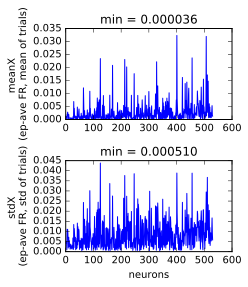

In [23]:
if doPlots:
    plt.figure
    plt.subplot(2,2,1)
    plt.plot(meanX)
    plt.ylabel('meanX \n(ep-ave FR, mean of trials)')
    plt.title('min = %.6f' %(np.min(meanX)))

    plt.subplot(2,2,3)
    plt.plot(stdX)
    plt.ylabel('stdX \n(ep-ave FR, std of trials)')
    plt.xlabel('neurons')
    plt.title('min = %.6f' %(np.min(stdX)))

    plt.tight_layout() #(pad=0.4, w_pad=0.5, h_pad=1.0)
    # plt.subplots_adjust(hspace=.5)

## Set the traces that will be used for projections and plotting 
    Traces are of size (frames x neurons x trials)
    Choose trials that will be used for projections (trs4project = 'trained', 'all', 'corr', 'incorr')
    Remove non-active neurons
    Do feature normalization and scaling for the traces (using mean and sd of X)

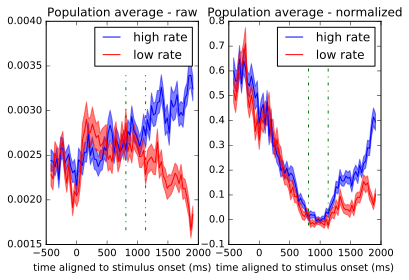

In [24]:
# trs4project = 'incorr' # 'trained', 'all', 'corr', 'incorr'

# Data = scio.loadmat(postName, variable_names=['outcomes', 'allResp_HR_LR'])
# choiceVecAll = (Data.pop('allResp_HR_LR').astype('float'))[0,:]

# Set trials that will be used for projection traces

if trs4project=='all': 
    Xt = traces_al_stim
    Xt_choiceAl = traces_al_1stSide
    Xt_goAl = traces_al_go
    Xt_rewAl = traces_al_rew
    Xt_incorrRespAl = traces_al_incorrResp
    Xt_initAl = traces_al_init
    Xt_stimAl_all = traces_al_stimAll
    choiceVecNow = choiceVecAll
elif trs4project=='trained':
    Xt = traces_al_stim[:, :, ~trsExcluded];
    Xt_choiceAl = traces_al_1stSide[:, :, ~trsExcluded];
    Xt_goAl = traces_al_go[:, :, ~trsExcluded];
    Xt_rewAl = traces_al_rew[:, :, ~trsExcluded];
    Xt_incorrRespAl = traces_al_incorrResp[:, :, ~trsExcluded];
    Xt_initAl = traces_al_init[:, :, ~trsExcluded];
    Xt_stimAl_all = traces_al_stimAll[:, :, ~trsExcluded];
    choiceVecNow = Y    
elif trs4project=='corr':
    Xt = traces_al_stim[:, :, outcomes==1];
    Xt_choiceAl = traces_al_1stSide[:, :, outcomes==1];
    Xt_goAl = traces_al_go[:, :, outcomes==1];
    Xt_rewAl = traces_al_rew[:, :, outcomes==1];
    Xt_incorrRespAl = traces_al_incorrResp[:, :, outcomes==1];
    Xt_initAl = traces_al_init[:, :, outcomes==1];
    Xt_stimAl_all = traces_al_stimAll[:, :, outcomes==1];
    choiceVecNow = choiceVecAll[outcomes==1]
    
elif trs4project=='incorr':
    Xt = traces_al_stim[:, :, outcomes==0];
    Xt_choiceAl = traces_al_1stSide[:, :, outcomes==0];
    Xt_goAl = traces_al_go[:, :, outcomes==0];
    Xt_rewAl = traces_al_rew[:, :, outcomes==0];
    Xt_incorrRespAl = traces_al_incorrResp[:, :, outcomes==0];
    Xt_initAl = traces_al_init[:, :, outcomes==0];
    Xt_stimAl_all = traces_al_stimAll[:, :, outcomes==0];
    choiceVecNow = choiceVecAll[outcomes==0]
    
## Xt = traces_al_stim[:, :, np.sum(np.sum(np.isnan(traces_al_stim), axis =0), axis =0)==0];
## Xt_choiceAl = traces_al_1stSide[:, :, np.sum(np.sum(np.isnan(traces_al_1stSide), axis =0), axis =0)==0];



# Exclude non-active neurons (ie neurons that don't fire in any of the trials during ep)
Xt = Xt[:,~NsExcluded,:]
Xt_choiceAl = Xt_choiceAl[:,~NsExcluded,:]
Xt_goAl = Xt_goAl[:,~NsExcluded,:]
Xt_rewAl = Xt_rewAl[:,~NsExcluded,:]
Xt_incorrRespAl = Xt_incorrRespAl[:,~NsExcluded,:]
Xt_initAl = Xt_initAl[:,~NsExcluded,:]
Xt_stimAl_all = Xt_stimAl_all[:,~NsExcluded,:]
    
# Only include the randomly selected set of neurons
Xt = Xt[:,NsRand,:]
Xt_choiceAl = Xt_choiceAl[:,NsRand,:]
Xt_goAl = Xt_goAl[:,NsRand,:]
Xt_rewAl = Xt_rewAl[:,NsRand,:]
Xt_incorrRespAl = Xt_incorrRespAl[:,NsRand,:]
Xt_initAl = Xt_initAl[:,NsRand,:]
Xt_stimAl_all = Xt_stimAl_all[:,NsRand,:]



# Divide data into high-rate (modeled as 1) and low-rate (modeled as 0) trials
hr_trs = (choiceVecNow==1)
lr_trs = (choiceVecNow==0)
# print 'Projection traces have %d high-rate trials, and %d low-rate trials' %(np.sum(hr_trs), np.sum(lr_trs))
    
    

# window of training (ep)
win = (ep-eventI)*frameLength

# Plot stim-aligned averages after centering and normalization
if doPlots:
    plt.figure()
    plt.subplot(1,2,1)
    a1 = np.nanmean(Xt[:, :, hr_trs],  axis=1) # frames x trials (average across neurons)
    tr1 = np.nanmean(a1,  axis = 1)
    tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
    a0 = np.nanmean(Xt[:, :, lr_trs],  axis=1) # frames x trials (average across neurons)
    tr0 = np.nanmean(a0,  axis = 1)
    tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
    mn = np.concatenate([tr1,tr0]).min()
    mx = np.concatenate([tr1,tr0]).max()
    plt.plot([win[0], win[0]], [mn, mx], 'g-.') # mark the begining and end of training window
    plt.plot([win[-1], win[-1]], [mn, mx], 'g-.')
    plt.fill_between(time_aligned_stim, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_stim, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_stim, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_stim, tr0, 'r', label = 'low rate')
    # plt.plot(time_aligned_stim, np.nanmean(Xt[:, :, lr_trs],  axis = (1, 2)), 'r', label = 'high rate')
    # plt.plot(time_aligned_stim, np.nanmean(Xt[:, :, hr_trs],  axis = (1, 2)), 'b', label = 'low rate')
    plt.xlabel('time aligned to stimulus onset (ms)')
    plt.title('Population average - raw')
    plt.legend()
    
    
    
    
    
    
## Feature normalization and scaling

# normalize stim-aligned traces
T, N, C = Xt.shape
Xt_N = np.reshape(Xt.transpose(0 ,2 ,1), (T*C, N), order = 'F')
Xt_N = (Xt_N-meanX)/stdX
Xt = np.reshape(Xt_N, (T, C, N), order = 'F').transpose(0 ,2 ,1)

# normalize goTome-aligned traces
Tg, Ng, Cg = Xt_goAl.shape
Xtg_N = np.reshape(Xt_goAl.transpose(0 ,2 ,1), (Tg*Cg, Ng), order = 'F')
Xtg_N = (Xtg_N-meanX)/stdX
Xtg = np.reshape(Xtg_N, (Tg, Cg, Ng), order = 'F').transpose(0 ,2 ,1)

# normalize choice-aligned traces
Tc, Nc, Cc = Xt_choiceAl.shape
Xtc_N = np.reshape(Xt_choiceAl.transpose(0 ,2 ,1), (Tc*Cc, Nc), order = 'F')
Xtc_N = (Xtc_N-meanX)/stdX
Xtc = np.reshape(Xtc_N, (Tc, Cc, Nc), order = 'F').transpose(0 ,2 ,1)

# normalize reward-aligned traces
Tr, Nr, Cr = Xt_rewAl.shape
Xtr_N = np.reshape(Xt_rewAl.transpose(0 ,2 ,1), (Tr*Cr, Nr), order = 'F')
Xtr_N = (Xtr_N-meanX)/stdX
Xtr = np.reshape(Xtr_N, (Tr, Cr, Nr), order = 'F').transpose(0 ,2 ,1)

# normalize commitIncorrect-aligned traces
Tp, Np, Cp = Xt_incorrRespAl.shape
Xtp_N = np.reshape(Xt_incorrRespAl.transpose(0 ,2 ,1), (Tp*Cp, Np), order = 'F')
Xtp_N = (Xtp_N-meanX)/stdX
Xtp = np.reshape(Xtp_N, (Tp, Cp, Np), order = 'F').transpose(0 ,2 ,1)

# normalize stimAll-aligned traces
Tsa, Nsa, Csa = Xt_stimAl_all.shape
Xtsa_N = np.reshape(Xt_stimAl_all.transpose(0 ,2 ,1), (Tsa*Csa, Nsa), order = 'F')
Xtsa_N = (Xtsa_N-meanX)/stdX
Xtsa = np.reshape(Xtsa_N, (Tsa, Csa, Nsa), order = 'F').transpose(0 ,2 ,1)

# normalize init-aligned traces
Ti, Ni, Ci = Xt_initAl.shape
Xti_N = np.reshape(Xt_initAl.transpose(0 ,2 ,1), (Ti*Ci, Ni), order = 'F')
Xti_N = (Xti_N-meanX)/stdX
Xti = np.reshape(Xti_N, (Ti, Ci, Ni), order = 'F').transpose(0 ,2 ,1)    

np.shape(Xt)


# window of training (ep)
# win = (ep-eventI)*frameLength

# Plot stim-aligned averages after centering and normalization
if doPlots:
#     plt.figure()
    plt.subplot(1,2,2)
    a1 = np.nanmean(Xt[:, :, hr_trs],  axis=1) # frames x trials (average across neurons)
    tr1 = np.nanmean(a1,  axis = 1)
    tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
    a0 = np.nanmean(Xt[:, :, lr_trs],  axis=1) # frames x trials (average across neurons)
    tr0 = np.nanmean(a0,  axis = 1)
    tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
    mn = np.concatenate([tr1,tr0]).min()
    mx = np.concatenate([tr1,tr0]).max()
    plt.plot([win[0], win[0]], [mn, mx], 'g-.') # mark the begining and end of training window
    plt.plot([win[-1], win[-1]], [mn, mx], 'g-.')
    plt.fill_between(time_aligned_stim, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_stim, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_stim, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_stim, tr0, 'r', label = 'low rate')
    # plt.plot(time_aligned_stim, np.nanmean(Xt[:, :, lr_trs],  axis = (1, 2)), 'r', label = 'high rate')
    # plt.plot(time_aligned_stim, np.nanmean(Xt[:, :, hr_trs],  axis = (1, 2)), 'b', label = 'low rate')
    plt.xlabel('time aligned to stimulus onset (ms)')
    plt.title('Population average - normalized')
    plt.legend()

## Identify the best regularization parameter
    Perform 10-fold cross validation to obtain the best regularization parameter
        More specifically: "crossValidateModel" divides data into training and test datasets. It calls linearSVM.py, which does linear SVM using XTrain, and returns percent class loss for XTrain and XTest.
    This procedure gets repeated for numSamples (100 times) for each value of regulariazation parameter. 
    An average across all 100 samples is computed to find the minimum test class loss.
    Best regularization parameter is defined as the smallest regularization parameter whose test-dataset class loss is within mean+sem of minimum test class loss.

In [25]:
# numSamples = 10; # number of iterations for finding the best c (inverse of regularization parameter)
# if you don't want to regularize, go with a very high cbest and don't run the section below.
# cbest = 10**6

regType = 'l1'
kfold = 10;
if regType == 'l1':
    print '\nRunning l1 svm classification\r' 
    # cvect = 10**(np.arange(-4, 6,0.2))/numTrials;
    cvect = 10**(np.arange(-4, 6,0.2))/numDataPoints;
elif regType == 'l2':
    print '\nRunning l2 svm classification\r' 
    cvect = 10**(np.arange(-4, 6,0.2));

print 'try the following regularization values: \n', cvect
# formattedList = ['%.2f' % member for member in cvect]
# print 'try the following regularization values = \n', formattedList

perClassErrorTrain = np.ones((numSamples, len(cvect)))+np.nan;
perClassErrorTest = np.ones((numSamples, len(cvect)))+np.nan;
for s in range(numSamples):
    for i in range(len(cvect)):
        if regType == 'l1':
            summary =  crossValidateModel(X, Y, linearSVM, kfold = kfold, l1 = cvect[i])
        elif regType == 'l2':
            summary =  crossValidateModel(X, Y, linearSVM, kfold = kfold, l2 = cvect[i])

        perClassErrorTrain[s, i] = summary.perClassErrorTrain;
        perClassErrorTest[s, i] = summary.perClassErrorTest;

meanPerClassErrorTrain = np.mean(perClassErrorTrain, axis = 0);
semPerClassErrorTrain = np.std(perClassErrorTrain, axis = 0)/np.sqrt(numSamples);

meanPerClassErrorTest = np.mean(perClassErrorTest, axis = 0);
semPerClassErrorTest = np.std(perClassErrorTest, axis = 0)/np.sqrt(numSamples);
ix = np.argmin(meanPerClassErrorTest);
cbest = cvect[meanPerClassErrorTest <= (meanPerClassErrorTest[ix]+semPerClassErrorTest[ix])];
cbest = cbest[0]; # best regularization term based on minError+SE criteria


Running l1 svm classification
try the following regularization values: 
[  4.14937759e-07   6.57632030e-07   1.04227653e-06   1.65189697e-06
   2.61808027e-06   4.14937759e-06   6.57632030e-06   1.04227653e-05
   1.65189697e-05   2.61808027e-05   4.14937759e-05   6.57632030e-05
   1.04227653e-04   1.65189697e-04   2.61808027e-04   4.14937759e-04
   6.57632030e-04   1.04227653e-03   1.65189697e-03   2.61808027e-03
   4.14937759e-03   6.57632030e-03   1.04227653e-02   1.65189697e-02
   2.61808027e-02   4.14937759e-02   6.57632030e-02   1.04227653e-01
   1.65189697e-01   2.61808027e-01   4.14937759e-01   6.57632030e-01
   1.04227653e+00   1.65189697e+00   2.61808027e+00   4.14937759e+00
   6.57632030e+00   1.04227653e+01   1.65189697e+01   2.61808027e+01
   4.14937759e+01   6.57632030e+01   1.04227653e+02   1.65189697e+02
   2.61808027e+02   4.14937759e+02   6.57632030e+02   1.04227653e+03
   1.65189697e+03   2.61808027e+03]


Best c (inverse of regularization parameter) = 1000000.00


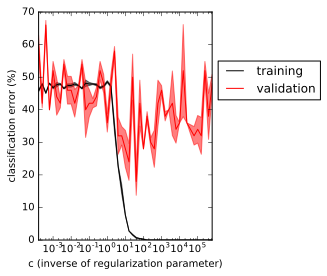

In [37]:
##%%%%%% plot coss-validation results
if doPlots:
    print 'Best c (inverse of regularization parameter) = %.2f' %cbest
    plt.figure('cross validation')
    plt.subplot(1,2,1)
    plt.fill_between(cvect, meanPerClassErrorTrain-semPerClassErrorTrain, meanPerClassErrorTrain+ semPerClassErrorTrain, alpha=0.5, edgecolor='k', facecolor='k')
    plt.fill_between(cvect, meanPerClassErrorTest-semPerClassErrorTest, meanPerClassErrorTest+ semPerClassErrorTest, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(cvect, meanPerClassErrorTrain, 'k', label = 'training')
    plt.plot(cvect, meanPerClassErrorTest, 'r', label = 'validation')
    plt.plot(cvect[cvect==cbest], meanPerClassErrorTest[cvect==cbest], 'bo')
    plt.xlim([cvect[1], cvect[-1]])
    plt.xscale('log')
    plt.xlabel('c (inverse of regularization parameter)')
    plt.ylabel('classification error (%)')
    plt.legend(loc='center left', bbox_to_anchor=(1, .7))
    plt.tight_layout()

## Train SVM model using the best regularization parameter
    All data in X are used for training.
    linear_svm is the trained SVM model that includes weights (w) and intercept (b).

In [38]:
if regType == 'l1':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l1', dual=False)
elif regType == 'l2':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l2', dual=True)

linear_svm.fit(X, Y)
    
w = np.squeeze(linear_svm.coef_);
b = linear_svm.intercept_;

trainE = abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100;

# keep a copy of linear_svm
import copy
linear_svm_0 = copy.deepcopy(linear_svm) 

Fraction of non-zero weight neurons = 1.00
Training error = 0.00%


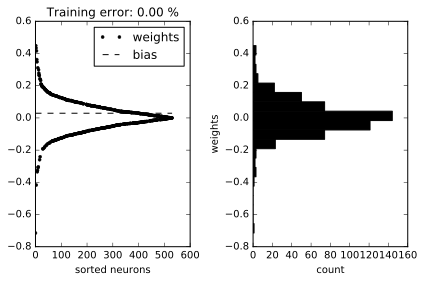

In [39]:
# Plot weights
if doPlots:
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(w[np.argsort(abs(w))[::-1]], 'k.', label = 'weights')
    plt.plot(np.ones(len(w))*b, 'k--', label = 'bias')
    plt.xlabel('sorted neurons')
    plt.legend()
    plt.title(('Training error: %.2f %%' %(trainE)))

    plt.subplot(1,2,2)
    plt.hist(w, 20,orientation='horizontal', color = 'k')
    plt.ylabel('weights')
    plt.xlabel('count')
    plt.tight_layout()

    # print abs(((np.dot(X,w)+b)>0).astype('float')-Y.astype('float')).sum()/len(Y)*100 # this is the prediction formula
    print 'Fraction of non-zero weight neurons = %.2f' %(np.mean(w!=0))
    print 'Training error = %.2f%%' %trainE


## Null distribution using shuffles
    Compute distritbutions of class loss for train and test datasets by fitting SVM for 100 times.
    Do this for both actual data and shuffled data (ie data in which Y is shuffled but X is not to serve as null distribution.)


In [40]:
numShuffles = 100
summary_data = [];
summary_shfl = [];
perClassErrorTrain_data = [];
perClassErrorTest_data = []
perClassErrorTrain_shfl = [];
perClassErrorTest_shfl = [];
w_data = []
b_data = []
w_shfl = []
b_shfl = []
permIxsList = [];
for i in range(numShuffles):
    # permIxs = rng.permutation(numTrials);
    permIxs = rng.permutation(numDataPoints);
    permIxsList.append(permIxs);
    if regType == 'l1':
        summary_data.append(crossValidateModel(X, Y, linearSVM, kfold = kfold, l1 = cbest))
        summary_shfl.append(crossValidateModel(X, Y[permIxs], linearSVM, kfold = kfold, l1 = cbest))
    elif regType == 'l2':
        summary_data.append(crossValidateModel(X, Y, linearSVM, kfold = kfold, l2 = cbest))
        summary_shfl.append(crossValidateModel(X, Y[permIxs], linearSVM, kfold = kfold, l2 = cbest))
        
    perClassErrorTrain_data.append(summary_data[i].perClassErrorTrain);
    perClassErrorTest_data.append(summary_data[i].perClassErrorTest);
    w_data.append(np.squeeze(summary_data[i].model.coef_));
    b_data.append(summary_data[i].model.intercept_);
        
    perClassErrorTrain_shfl.append(summary_shfl[i].perClassErrorTrain);
    perClassErrorTest_shfl.append(summary_shfl[i].perClassErrorTest);
    w_shfl.append(np.squeeze(summary_shfl[i].model.coef_));
    b_shfl.append(summary_shfl[i].model.intercept_);

Training error: Mean actual: 0.00%, Mean shuffled: 0.00%, p-value = 1.00
Testing error: Mean actual: 39.32%, Mean shuffled: 50.68%, p-value = 0.00


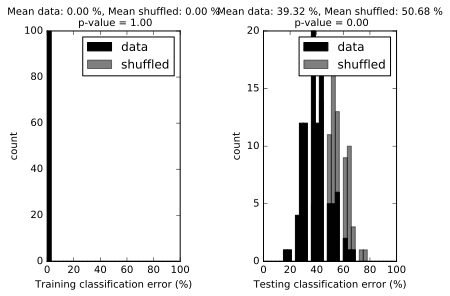

In [41]:
pvalueTrain = ttest2(perClassErrorTrain_data, perClassErrorTrain_shfl, tail = 'left');
pvalueTest = ttest2(perClassErrorTest_data, perClassErrorTest_shfl, tail = 'left');

print 'Training error: Mean actual: %.2f%%, Mean shuffled: %.2f%%, p-value = %.2f' %(np.mean(perClassErrorTrain_data), np.mean(perClassErrorTrain_shfl), pvalueTrain)
print 'Testing error: Mean actual: %.2f%%, Mean shuffled: %.2f%%, p-value = %.2f' %(np.mean(perClassErrorTest_data), np.mean(perClassErrorTest_shfl), pvalueTest)


# Plot the histograms
if doPlots:
    binEvery = 3; # bin width
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.hist(perClassErrorTrain_data, np.arange(0,100,binEvery), color = 'k', label = 'data');
    plt.hist(perClassErrorTrain_shfl, np.arange(0,100,binEvery), color = 'k', alpha=.5, label = 'shuffled');
    plt.xlabel('Training classification error (%)')
    plt.ylabel('count')
    plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%\n p-value = %.2f' %(np.mean(perClassErrorTrain_data), np.mean(perClassErrorTrain_shfl), pvalueTrain), fontsize = 10)
    plt.legend()

    plt.subplot(1,2,2)
    plt.hist(perClassErrorTest_data, np.arange(0,100,binEvery), color = 'k', label = 'data');
    plt.hist(perClassErrorTest_shfl, np.arange(0,100,binEvery), color = 'k', alpha=.5, label = 'shuffled');
    plt.legend()
    plt.xlabel('Testing classification error (%)')
    plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%\n p-value = %.2f' %(np.mean(perClassErrorTest_data), np.mean(perClassErrorTest_shfl), pvalueTest), fontsize = 10)
    plt.ylabel('count')
    plt.tight_layout(pad=0.4, w_pad=1.5, h_pad=1.0)

In [ ]:
# Train SVM using different number of neurons, and compute training/testing error
'''
# if you don't want to regularize, go with a very high cbest and don't run the section below.
cbest = 10**6

if regType == 'l1':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l1', dual=False)
elif regType == 'l2':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l2', dual=True)
    

numShuffles = 100 # for cross validation and null distributions    
perClassErrorTrain_data_nN_all = []  # includes all shuffle values of all subselects of nN neurons for each value of nN
perClassErrorTest_data_nN_all = []
perClassErrorTrain_shfl_nN_all = [];
perClassErrorTest_shfl_nN_all = [];
# numShufflesN = 100 # for selecting nN neurons
# Train using different number of neurons
for nN in [x+1 for x in range(np.shape(X)[1])]: # nN = 1:totalNumNeurons 

    # select nN random neurons from X, do this numShufflesN times
    numShufflesN = 2*np.ceil(np.shape(X)[1]/float(nN)).astype(int) # if you are selecting only 1 neuron out of 500 neurons, you will do this 500 times to get a selection of all neurons. On the other hand if you are selecting 400 neurons out of 500 neurons, you will do this only once.
    perClassErrorTrain_data_nN = [];
    perClassErrorTest_data_nN = []
    perClassErrorTrain_shfl_nN = [];
    perClassErrorTest_shfl_nN = [];
    
    for ii in range(numShufflesN):
        inds = rng.permutation(np.shape(X)[1])
        inds = inds[range(nN)]
        Xnow = X[:,inds]

        '''
        linear_svm.fit(Xnow, Y)    

        w = np.squeeze(linear_svm.coef_);
        b = linear_svm.intercept_;

        trainE = abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100;

        # keep a copy of linear_svm
        import copy
        linear_svm_0 = copy.deepcopy(linear_svm) 
        '''

        # Null distributions
#         numShuffles = 100 # for cross validation
        summary_data = [];
        summary_shfl = [];
        perClassErrorTrain_data = [];
        perClassErrorTest_data = []
        perClassErrorTrain_shfl = [];
        perClassErrorTest_shfl = [];
        w_data = []
        b_data = []
        w_shfl = []
        b_shfl = []
        permIxsList = [];
        for i in range(numShuffles):
            # permIxs = rng.permutation(numTrials);
            permIxs = rng.permutation(numDataPoints);
            permIxsList.append(permIxs);
            if regType == 'l1':
                summary_data.append(crossValidateModel(Xnow, Y, linearSVM, kfold = kfold, l1 = cbest))
                summary_shfl.append(crossValidateModel(Xnow, Y[permIxs], linearSVM, kfold = kfold, l1 = cbest))
            elif regType == 'l2':
                summary_data.append(crossValidateModel(Xnow, Y, linearSVM, kfold = kfold, l2 = cbest))
                summary_shfl.append(crossValidateModel(Xnow, Y[permIxs], linearSVM, kfold = kfold, l2 = cbest))

            perClassErrorTrain_data.append(summary_data[i].perClassErrorTrain);
            perClassErrorTest_data.append(summary_data[i].perClassErrorTest);
            w_data.append(np.squeeze(summary_data[i].model.coef_));
            b_data.append(summary_data[i].model.intercept_);

            perClassErrorTrain_shfl.append(summary_shfl[i].perClassErrorTrain);
            perClassErrorTest_shfl.append(summary_shfl[i].perClassErrorTest);
            w_shfl.append(np.squeeze(summary_shfl[i].model.coef_));
            b_shfl.append(summary_shfl[i].model.intercept_);

        # concatenate the 100 shuffles for all random sets of nN neurons
        perClassErrorTrain_data_nN.append(perClassErrorTrain_data) 
        perClassErrorTest_data_nN.append(perClassErrorTest_data)
        perClassErrorTrain_shfl_nN.append(perClassErrorTrain_shfl)
        perClassErrorTest_shfl_nN.append(perClassErrorTest_shfl)
    
    
    # keep values for each nN     
    perClassErrorTrain_data_nN_all.append(perClassErrorTrain_data_nN)
    perClassErrorTest_data_nN_all.append(perClassErrorTest_data_nN)
    perClassErrorTrain_shfl_nN_all.append(perClassErrorTrain_shfl_nN)
    perClassErrorTest_shfl_nN_all.append(perClassErrorTest_shfl_nN)
'''

## Project traces onto SVM weights
    Stimulus-aligned, choice-aligned, etc traces projected onto SVM fitted weights.
    More specifically, project traces of all trials onto normalized w (ie SVM weights computed from fitting model using X and Y of all trials).

In [26]:
if doPlots:
    # w = np.zeros(numNeurons)
    w_normalized = w/sci.linalg.norm(w);

    # stim-aligned traces
    # XtN_w = np.dot(Xt_N, w_normalized);
    # Xt_w = np.reshape(XtN_w, (T,C), order='F');
    # I think below can replace above, test it....
    XtN_w = np.dot(Xtsa_N, w_normalized);
    Xt_w = np.reshape(XtN_w, (Tsa,Csa), order='F');


    # goTone-aligned 
    XtgN_w = np.dot(Xtg_N, w_normalized);
    Xtg_w = np.reshape(XtgN_w, (Tg,Cg), order='F');

    # choice-aligned 
    XtcN_w = np.dot(Xtc_N, w_normalized);
    Xtc_w = np.reshape(XtcN_w, (Tc,Cc), order='F');

    # reward-aligned 
    XtrN_w = np.dot(Xtr_N, w_normalized);
    Xtr_w = np.reshape(XtrN_w, (Tr,Cr), order='F');

    # incommitResp-aligned 
    XtpN_w = np.dot(Xtp_N, w_normalized);
    Xtp_w = np.reshape(XtpN_w, (Tp,Cp), order='F');

    # initTone-aligned 
    XtiN_w = np.dot(Xti_N, w_normalized);
    Xti_w = np.reshape(XtiN_w, (Ti,Ci), order='F');

/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


## Plot projections and raw averages of neural population responses

/home/farznaj/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


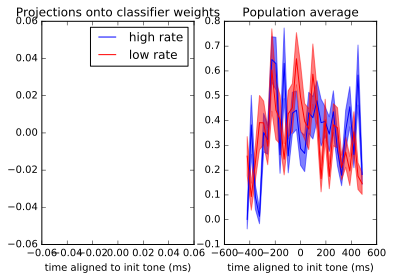

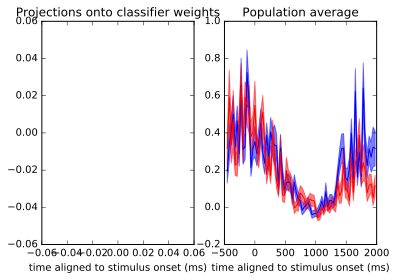

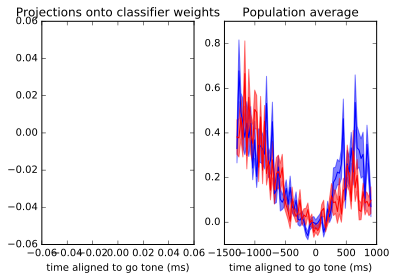

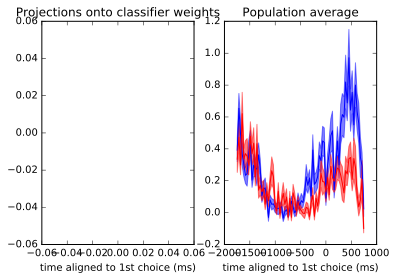

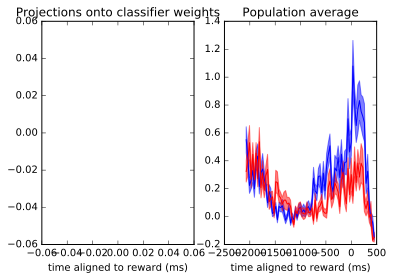

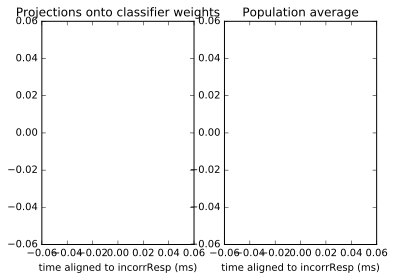

In [27]:
if doPlots:
    # window of training (ep)
    # win = (ep-eventI)*frameLength

    # init-aligned projections and raw average
    plt.figure()
    plt.subplot(1,2,1)
    tr1 = np.nanmean(Xti_w[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xti_w[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xti_w[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xti_w[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_init, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_init, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_init, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_init, tr0, 'r', label = 'low rate')
    # tr1=np.nanmean(Xtc_w[:, hr_trs],  axis = 1)
    # tr0=np.nanmean(Xtc_w[:, lr_trs],  axis = 1)
    # plt.plot(time_aligned_1stSide, tr1, 'r', label = 'high rate')
    # plt.plot(time_aligned_1stSide, tr0, 'b', label = 'low rate')
    plt.xlabel('time aligned to init tone (ms)')
    plt.title('Projections onto classifier weights')
    plt.legend()

    plt.subplot(1,2,2)
    a1 = np.nanmean(Xti[:, :, hr_trs],  axis=1) # frames x trials
    tr1 = np.nanmean(a1,  axis = 1)
    tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
    a0 = np.nanmean(Xti[:, :, lr_trs],  axis=1) # frames x trials
    tr0 = np.nanmean(a0,  axis = 1)
    tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_init, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_init, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_init, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_init, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to init tone (ms)')
    plt.title('Population average')
    # plt.legend()



    # stim-aligned projections and raw average
    plt.figure()
    plt.subplot(1,2,1)
    tr1 = np.nanmean(Xt_w[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xt_w[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xt_w[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xt_w[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_stim, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_stim, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_stim, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_stim, tr0, 'r', label = 'low rate')
    mn = np.concatenate([tr1,tr0]).min()
    mx = np.concatenate([tr1,tr0]).max()
    plt.plot([win[0], win[0]], [mn, mx], 'g-.') # mark the begining and end of training window
    plt.plot([win[-1], win[-1]], [mn, mx], 'g-.')
    plt.xlabel('time aligned to stimulus onset (ms)')
    plt.title('Projections onto classifier weights')
    # plt.legend()

    plt.subplot(1,2,2) # I think you should use Xtsa here to make it compatible with the plot above.
    a1 = np.nanmean(Xt[:, :, hr_trs],  axis=1) # frames x trials (average across neurons)
    tr1 = np.nanmean(a1,  axis = 1)
    tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
    a0 = np.nanmean(Xt[:, :, lr_trs],  axis=1) # frames x trials (average across neurons)
    tr0 = np.nanmean(a0,  axis = 1)
    tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_stim, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_stim, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_stim, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_stim, tr0, 'r', label = 'low rate')
    # plt.plot(time_aligned_stim, np.nanmean(Xt[:, :, lr_trs],  axis = (1, 2)), 'r', label = 'high rate')
    # plt.plot(time_aligned_stim, np.nanmean(Xt[:, :, hr_trs],  axis = (1, 2)), 'b', label = 'low rate')
    plt.xlabel('time aligned to stimulus onset (ms)')
    plt.title('Population average')
    # plt.legend()



    # goTone-aligned projections and raw average
    plt.figure()
    plt.subplot(1,2,1)
    tr1 = np.nanmean(Xtg_w[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xtg_w[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xtg_w[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xtg_w[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_go, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_go, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_go, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_go, tr0, 'r', label = 'low rate')
    # tr1=np.nanmean(Xtc_w[:, hr_trs],  axis = 1)
    # tr0=np.nanmean(Xtc_w[:, lr_trs],  axis = 1)
    # plt.plot(time_aligned_1stSide, tr1, 'r', label = 'high rate')
    # plt.plot(time_aligned_1stSide, tr0, 'b', label = 'low rate')
    plt.xlabel('time aligned to go tone (ms)')
    plt.title('Projections onto classifier weights')
    # plt.legend()


    plt.subplot(1,2,2)
    a1 = np.nanmean(Xtg[:, :, hr_trs],  axis=1) # frames x trials
    tr1 = np.nanmean(a1,  axis = 1)
    tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
    a0 = np.nanmean(Xtg[:, :, lr_trs],  axis=1) # frames x trials
    tr0 = np.nanmean(a0,  axis = 1)
    tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_go, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_go, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_go, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_go, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to go tone (ms)')
    plt.title('Population average')
    # plt.legend()



    # choice-aligned projections and raw average
    plt.figure()
    plt.subplot(1,2,1)
    tr1 = np.nanmean(Xtc_w[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xtc_w[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xtc_w[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xtc_w[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_1stSide, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_1stSide, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_1stSide, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_1stSide, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to 1st choice (ms)')
    plt.title('Projections onto classifier weights')
    # plt.legend()


    plt.subplot(1,2,2)
    a1 = np.nanmean(Xtc[:, :, hr_trs],  axis=1) # frames x trials
    tr1 = np.nanmean(a1,  axis = 1)
    tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
    a0 = np.nanmean(Xtc[:, :, lr_trs],  axis=1) # frames x trials
    tr0 = np.nanmean(a0,  axis = 1)
    tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_1stSide, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_1stSide, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_1stSide, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_1stSide, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to 1st choice (ms)')
    plt.title('Population average')
    # plt.legend()




    # reward-aligned projections and raw average
    plt.figure()
    plt.subplot(1,2,1)
    tr1 = np.nanmean(Xtr_w[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xtr_w[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xtr_w[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xtr_w[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_rew, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_rew, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_rew, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_rew, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to reward (ms)')
    plt.title('Projections onto classifier weights')
    # plt.legend()


    plt.subplot(1,2,2)
    a1 = np.nanmean(Xtr[:, :, hr_trs],  axis=1) # frames x trials
    tr1 = np.nanmean(a1,  axis = 1)
    tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
    a0 = np.nanmean(Xtr[:, :, lr_trs],  axis=1) # frames x trials
    tr0 = np.nanmean(a0,  axis = 1)
    tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_rew, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_rew, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_rew, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_rew, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to reward (ms)')
    plt.title('Population average')
    # plt.legend()




    # incommitResp-aligned projections and raw average
    plt.figure()
    plt.subplot(1,2,1)
    tr1 = np.nanmean(Xtp_w[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xtp_w[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xtp_w[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xtp_w[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_incorrResp, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_incorrResp, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_incorrResp, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_incorrResp, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to incorrResp (ms)')
    plt.title('Projections onto classifier weights')
    # plt.legend()


    plt.subplot(1,2,2)
    a1 = np.nanmean(Xtp[:, :, hr_trs],  axis=1) # frames x trials
    tr1 = np.nanmean(a1,  axis = 1)
    tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
    a0 = np.nanmean(Xtp[:, :, lr_trs],  axis=1) # frames x trials
    tr0 = np.nanmean(a0,  axis = 1)
    tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_incorrResp, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_incorrResp, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_incorrResp, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_incorrResp, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to incorrResp (ms)')
    plt.title('Population average')
    # plt.legend()
    # plt.tight_layout()

## Classification accuracy at each time point
    Same trials that went into projection traces will be used here.

In [28]:
# perClassCorr_t = [];
# corrClass = np.ones((T, numTrials)) + np.nan # frames x trials

# temp = Xti # for trial-history you may want to use this:
temp = Xt # stimulus-aligned traces (I think you should use Xtsa for consistency... u get projections from Xtsa)
nnf, nnu, nnt = temp.shape
corrClass = np.ones((T, nnt)) + np.nan # frames x trials

# if trs4project!='trained':  # onlyTrainedTrs==0: 
#     temp = temp[:,:,~trsExcluded] # make sure it has same size as Y, you need this for svm.predict below. 
for t in range(T):
    trac = np.squeeze(temp[t, :, :]).T # trials x neurons  # stimulus-aligned trace at time t
    corrFract = 1 - abs(linear_svm.predict(trac)-choiceVecNow); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
    # corrFract = 1 - abs(linear_svm.predict(trac)-Y); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
    corrClass[t,:] = corrFract # frames x trials % fraction correct classification for all trials
    # perClassCorr_t.append(corrFract.mean()*100) # average correct classification across trials for time point t. Same as np.mean(corrClass, axis=1)    
    
    # shuffled data
    for i in range(numSamples)
        permIxs = rng.permutation(numDataPoints);
        corrFractSh = 1 - abs(linear_svm.predict(trac)-choiceVecNow[permIxs]);
    corrFractShfl = np.mean(corrFractSh,axis=None) # average of trials across shuffles
    corrClassShfl[t,:] = corrFract # frames x trials
    

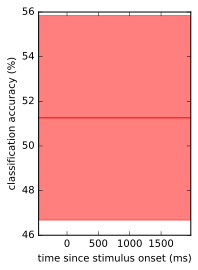

In [29]:
# Plot class accuracy
if doPlots:
    a = np.mean(corrClass, axis=1)*100 
    s = np.std(corrClass, axis=1)*100 /np.sqrt(numTrials);

    plt.figure()
    plt.subplot(1,2,1)
    plt.fill_between(time_aligned_stim, a-s, a+s, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_stim, a, 'r')
    plt.xlabel('time since stimulus onset (ms)')
    plt.ylabel('classification accuracy (%)')
    plt.xlim([time_aligned_stim[0], time_aligned_stim[-1]])

# Comparison of Excitatory and Inhibitory Neurons 

## Compare weights of inhibitory and excitatory neurons


mean(abs(w)): inhibit = 0.000  excit = 0.000
p-val_2tailed (inhibit vs excit weights) = nan


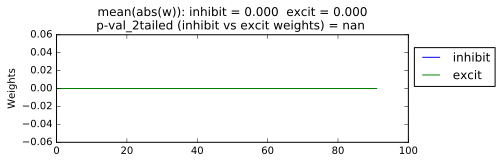

In [30]:
if doPlots and neuronType==2:
    w_inh = w[inhRois==1]
    w_exc = w[inhRois==0]
    
    plt.figure()
    plt.subplot(2,1,2)
    plt.plot(w_inh, label = 'inhibit')
    plt.plot(w_exc, label = 'excit')
    plt.ylabel('Weights')
    plt.legend(loc='center left', bbox_to_anchor=(1, .7))    

    h, p = stats.ttest_ind(w_inh, w_exc)
    
    plt.title('mean(abs(w)): inhibit = %.3f  excit = %.3f\np-val_2tailed (inhibit vs excit weights) = %.2f ' %(np.mean(abs(w_inh)), np.mean(abs(w_exc)), p))
    plt.tight_layout()
    
    
    print '\nmean(abs(w)): inhibit = %.3f  excit = %.3f' %(np.mean(abs(w_inh)), np.mean(abs(w_exc)))
    print 'p-val_2tailed (inhibit vs excit weights) = %.2f' %p
    # p_tl = ttest2(w_inh, w_exc, tail='left')
    # print 'p-val_left_tailed (inhibit vs excit weights) = %.2f' %p_tl

## Compare projections for when only excitatory vs. only inhibitory neurons are contributing to the decoder

In [31]:
if doPlots and neuronType==2:

    # Set weights of excit neurons to 0 and project the traces onto this new decoder that cares only about inhibitory neurons.

    ww = w+0;
    ww[inhRois==0] = 0

    w_normalized = ww/sci.linalg.norm(w);

    # stim-aligned traces
    # XtN_w = np.dot(Xt_N, w_normalized);
    # Xt_w = np.reshape(XtN_w, (T,C), order='F');
    # I think below can replace above, test it....
    XtN_w = np.dot(Xtsa_N, w_normalized);
    Xt_w_i = np.reshape(XtN_w, (Tsa,Csa), order='F');


    # goTone-aligned 
    XtgN_w = np.dot(Xtg_N, w_normalized);
    Xtg_w_i = np.reshape(XtgN_w, (Tg,Cg), order='F');

    # choice-aligned 
    XtcN_w = np.dot(Xtc_N, w_normalized);
    Xtc_w_i = np.reshape(XtcN_w, (Tc,Cc), order='F');

    # reward-aligned 
    XtrN_w = np.dot(Xtr_N, w_normalized);
    Xtr_w_i = np.reshape(XtrN_w, (Tr,Cr), order='F');

    # incommitResp-aligned 
    XtpN_w = np.dot(Xtp_N, w_normalized);
    Xtp_w_i = np.reshape(XtpN_w, (Tp,Cp), order='F');

    # initTone-aligned 
    XtiN_w = np.dot(Xti_N, w_normalized);
    Xti_w_i = np.reshape(XtiN_w, (Ti,Ci), order='F');



    # Set weights of inhibit neurons to 0 and project the traces onto this new decoder that cares only about the excitatory neurons.

    ww = w+0;
    ww[inhRois==1] = 0

    w_normalized = ww/sci.linalg.norm(w);

    # stim-aligned traces
    # XtN_w = np.dot(Xt_N, w_normalized);
    # Xt_w = np.reshape(XtN_w, (T,C), order='F');
    # I think below can replace above, test it....
    XtN_w = np.dot(Xtsa_N, w_normalized);
    Xt_w_e = np.reshape(XtN_w, (Tsa,Csa), order='F');


    # goTone-aligned 
    XtgN_w = np.dot(Xtg_N, w_normalized);
    Xtg_w_e = np.reshape(XtgN_w, (Tg,Cg), order='F');

    # choice-aligned 
    XtcN_w = np.dot(Xtc_N, w_normalized);
    Xtc_w_e = np.reshape(XtcN_w, (Tc,Cc), order='F');

    # reward-aligned 
    XtrN_w = np.dot(Xtr_N, w_normalized);
    Xtr_w_e = np.reshape(XtrN_w, (Tr,Cr), order='F');

    # incommitResp-aligned 
    XtpN_w = np.dot(Xtp_N, w_normalized);
    Xtp_w_e = np.reshape(XtpN_w, (Tp,Cp), order='F');

    # initTone-aligned 
    XtiN_w = np.dot(Xti_N, w_normalized);
    Xti_w_e = np.reshape(XtiN_w, (Ti,Ci), order='F');

/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide
/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in divide


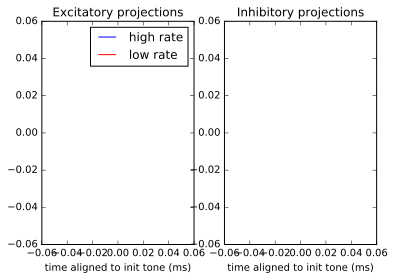

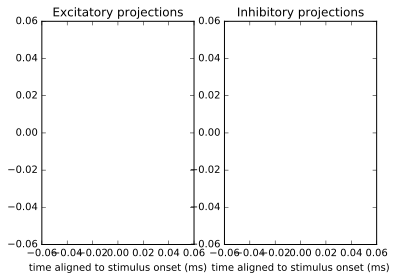

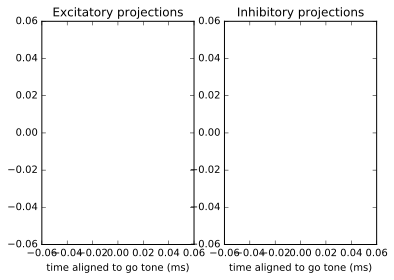

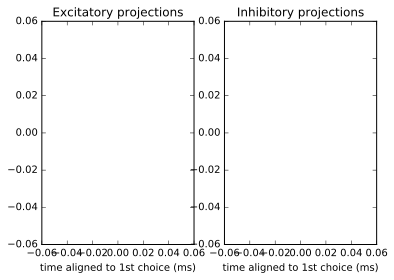

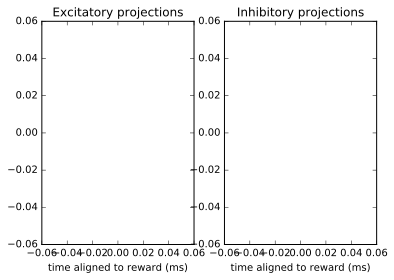

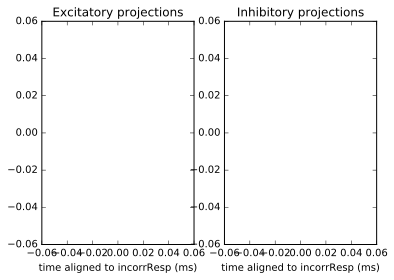

In [32]:
# Plot the excitatory vs inhibitory projections
if doPlots and neuronType==2:

    # window of training (ep)
    # win = (ep-eventI)*frameLength

    # init-aligned projections: excit vs inhibit
    plt.figure()
    plt.subplot(1,2,1)
    tr1 = np.nanmean(Xti_w_e[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xti_w_e[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xti_w_e[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xti_w_e[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_init, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_init, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_init, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_init, tr0, 'r', label = 'low rate')
    # tr1=np.nanmean(Xtc_w[:, hr_trs],  axis = 1)
    # tr0=np.nanmean(Xtc_w[:, lr_trs],  axis = 1)
    # plt.plot(time_aligned_1stSide, tr1, 'r', label = 'high rate')
    # plt.plot(time_aligned_1stSide, tr0, 'b', label = 'low rate')
    plt.xlabel('time aligned to init tone (ms)')
    plt.title('Excitatory projections')
    plt.legend()

    plt.subplot(1,2,2)
    tr1 = np.nanmean(Xti_w_i[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xti_w_i[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xti_w_i[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xti_w_i[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_init, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_init, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_init, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_init, tr0, 'r', label = 'low rate')
    # tr1=np.nanmean(Xtc_w[:, hr_trs],  axis = 1)
    # tr0=np.nanmean(Xtc_w[:, lr_trs],  axis = 1)
    # plt.plot(time_aligned_1stSide, tr1, 'r', label = 'high rate')
    # plt.plot(time_aligned_1stSide, tr0, 'b', label = 'low rate')
    plt.xlabel('time aligned to init tone (ms)')
    plt.title('Inhibitory projections')
    # plt.legend()



    # stim-aligned projections: excit vs inhibit
    plt.figure()
    plt.subplot(1,2,1)
    tr1 = np.nanmean(Xt_w_e[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xt_w_e[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xt_w_e[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xt_w_e[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_stim, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_stim, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_stim, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_stim, tr0, 'r', label = 'low rate')
    mn = np.concatenate([tr1,tr0]).min()
    mx = np.concatenate([tr1,tr0]).max()
    plt.plot([win[0], win[0]], [mn, mx], 'g-.') # mark the begining and end of training window
    plt.plot([win[-1], win[-1]], [mn, mx], 'g-.')
    plt.xlabel('time aligned to stimulus onset (ms)')
    plt.title('Excitatory projections')
    # plt.legend()

    plt.subplot(1,2,2)
    tr1 = np.nanmean(Xt_w_i[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xt_w_i[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xt_w_i[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xt_w_i[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_stim, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_stim, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_stim, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_stim, tr0, 'r', label = 'low rate')
    mn = np.concatenate([tr1,tr0]).min()
    mx = np.concatenate([tr1,tr0]).max()
    plt.plot([win[0], win[0]], [mn, mx], 'g-.') # mark the begining and end of training window
    plt.plot([win[-1], win[-1]], [mn, mx], 'g-.')
    plt.xlabel('time aligned to stimulus onset (ms)')
    plt.title('Inhibitory projections')
    # plt.legend()



    # goTone-aligned projections: excit vs inhibit
    plt.figure()
    plt.subplot(1,2,1)
    tr1 = np.nanmean(Xtg_w_e[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xtg_w_e[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xtg_w_e[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xtg_w_e[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_go, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_go, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_go, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_go, tr0, 'r', label = 'low rate')
    # tr1=np.nanmean(Xtc_w[:, hr_trs],  axis = 1)
    # tr0=np.nanmean(Xtc_w[:, lr_trs],  axis = 1)
    # plt.plot(time_aligned_1stSide, tr1, 'r', label = 'high rate')
    # plt.plot(time_aligned_1stSide, tr0, 'b', label = 'low rate')
    plt.xlabel('time aligned to go tone (ms)')
    plt.title('Excitatory projections')
    # plt.legend()


    plt.subplot(1,2,2)
    tr1 = np.nanmean(Xtg_w_i[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xtg_w_i[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xtg_w_i[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xtg_w_i[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_go, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_go, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_go, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_go, tr0, 'r', label = 'low rate')
    # tr1=np.nanmean(Xtc_w[:, hr_trs],  axis = 1)
    # tr0=np.nanmean(Xtc_w[:, lr_trs],  axis = 1)
    # plt.plot(time_aligned_1stSide, tr1, 'r', label = 'high rate')
    # plt.plot(time_aligned_1stSide, tr0, 'b', label = 'low rate')
    plt.xlabel('time aligned to go tone (ms)')
    plt.title('Inhibitory projections')
    # plt.legend()



    # choice-aligned projections: excit vs inhibit
    plt.figure()
    plt.subplot(1,2,1)
    tr1 = np.nanmean(Xtc_w_e[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xtc_w_e[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xtc_w_e[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xtc_w_e[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_1stSide, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_1stSide, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_1stSide, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_1stSide, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to 1st choice (ms)')
    plt.title('Excitatory projections')
    # plt.legend()


    plt.subplot(1,2,2)
    tr1 = np.nanmean(Xtc_w_i[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xtc_w_i[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xtc_w_i[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xtc_w_i[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_1stSide, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_1stSide, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_1stSide, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_1stSide, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to 1st choice (ms)')
    plt.title('Inhibitory projections')
    # plt.legend()




    # reward-aligned projections: excit vs inhibit
    plt.figure()
    plt.subplot(1,2,1)
    tr1 = np.nanmean(Xtr_w_e[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xtr_w_e[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xtr_w_e[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xtr_w_e[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_rew, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_rew, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_rew, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_rew, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to reward (ms)')
    plt.title('Excitatory projections')
    # plt.legend()


    plt.subplot(1,2,2)
    tr1 = np.nanmean(Xtr_w_i[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xtr_w_i[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xtr_w_i[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xtr_w_i[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_rew, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_rew, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_rew, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_rew, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to reward (ms)')
    plt.title('Inhibitory projections')
    # plt.legend()




    # incommitResp-aligned projections: excit vs inhibit
    plt.figure()
    plt.subplot(1,2,1)
    tr1 = np.nanmean(Xtp_w_e[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xtp_w_e[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xtp_w_e[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xtp_w_e[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_incorrResp, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_incorrResp, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_incorrResp, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_incorrResp, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to incorrResp (ms)')
    plt.title('Excitatory projections')
    # plt.legend()


    plt.subplot(1,2,2)
    tr1 = np.nanmean(Xtp_w_i[:, hr_trs],  axis = 1)
    tr1_se = np.nanstd(Xtp_w_i[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
    tr0 = np.nanmean(Xtp_w_i[:, lr_trs],  axis = 1)
    tr0_se = np.nanstd(Xtp_w_i[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
    plt.fill_between(time_aligned_incorrResp, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
    plt.fill_between(time_aligned_incorrResp, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_incorrResp, tr1, 'b', label = 'high rate')
    plt.plot(time_aligned_incorrResp, tr0, 'r', label = 'low rate')
    plt.xlabel('time aligned to incorrResp (ms)')
    plt.title('Inhibitory projections')
    # plt.legend()
    # plt.tight_layout()

## Compute classification error of training and testing dataset for the following cases:
    Here we train the classifier using the best c found above (when including all neurons in the decoder) but using different sets of neurons and 90% training, 10% testing trials.
    
    1) All inhibitory neurons contribute to the decoder
    2) N excitatory neurons contribute, where n = number of inhibitory neurons. 
    3) All excitatory neurons contribute

In [33]:
if neuronType==2:
    
    Xinh = X[:, inhRois==1]
    XallExc = X[:, inhRois==0]
    lenInh = (inhRois==1).sum()
    excI = np.argwhere(inhRois==0)  
    
    numShuffles = 100 
    numShufflesExc = 10 # we choose n random excitatory neurons, how many times to do this?

    summary_data_inh = [];
    summary_shfl_inh = [];
    summary_data_allExc = [];
    summary_shfl_allExc = [];
    summary_data_exc = [];
    summary_shfl_exc = [];
    perClassErrorTrain_data_inh = [];
    perClassErrorTest_data_inh = []
    perClassErrorTrain_shfl_inh = [];
    perClassErrorTest_shfl_inh = [];
    w_data_inh = []
    b_data_inh = []
    w_shfl_inh = []
    b_shfl_inh = []
    perClassErrorTrain_data_allExc = [];
    perClassErrorTest_data_allExc = []
    perClassErrorTrain_shfl_allExc = [];
    perClassErrorTest_shfl_allExc = [];
    w_data_allExc = []
    b_data_allExc = []
    w_shfl_allExc = []
    b_shfl_allExc = []
    perClassErrorTrain_data_exc = [];
    perClassErrorTest_data_exc = []
    perClassErrorTrain_shfl_exc = [];
    perClassErrorTest_shfl_exc = [];
    w_data_exc = []
    b_data_exc = []
    w_shfl_exc = []
    b_shfl_exc = []

    permIxsList = [];
    counter = 0    
    
    for i in range(numShuffles):
        # permIxs = rng.permutation(numTrials);
        permIxs = rng.permutation(numDataPoints);
        permIxsList.append(permIxs);    

        if regType == 'l1':
            # all inh            
            summary_data_inh.append(crossValidateModel(Xinh, Y, linearSVM, kfold = kfold, l1 = cbest))
            summary_shfl_inh.append(crossValidateModel(Xinh, Y[permIxs], linearSVM, kfold = kfold, l1 = cbest))


            # all exc            
            summary_data_allExc.append(crossValidateModel(XallExc, Y, linearSVM, kfold = kfold, l1 = cbest))
            summary_shfl_allExc.append(crossValidateModel(XallExc, Y[permIxs], linearSVM, kfold = kfold, l1 = cbest))


            # n exc (n = number of inh)        
            # select n random exc (n = number of inh)
            for ii in range(numShufflesExc):            
                en = rng.permutation(excI)[0:lenInh].squeeze() # n randomly selected exc neurons.
                Xexc = X[:, en]
                summary_data_exc.append(crossValidateModel(Xexc, Y, linearSVM, kfold = kfold, l1 = cbest)) # summary_data_exc is of size numShuffles x numShufflesExc
                summary_shfl_exc.append(crossValidateModel(Xexc, Y[permIxs], linearSVM, kfold = kfold, l1 = cbest))

                counter = counter+1
    #             print en
#             print counter
            inds = np.arange(counter-numShufflesExc,counter)
#             print inds


        elif regType == 'l2':
            # all inh
            summary_data_inh.append(crossValidateModel(Xinh, Y, linearSVM, kfold = kfold, l2 = cbest))
            summary_shfl_inh.append(crossValidateModel(Xinh, Y[permIxs], linearSVM, kfold = kfold, l2 = cbest))


            # all exc
            summary_data_allExc.append(crossValidateModel(XallExc, Y, linearSVM, kfold = kfold, l2 = cbest))
            summary_shfl_allExc.append(crossValidateModel(XallExc, Y[permIxs], linearSVM, kfold = kfold, l2 = cbest))


            # n exc (n = number of inh)     
            for ii in range(numShufflesExc):
                Xexc = X[:, en]
                summary_data_exc.append(crossValidateModel(Xexc, Y, linearSVM, kfold = kfold, l2 = cbest))
                summary_shfl_exc.append(crossValidateModel(Xexc, Y[permIxs], linearSVM, kfold = kfold, l2 = cbest))

                counter = counter+1
#             print counter
            inds = np.arange(counter-numShufflesExc,counter)
#             print inds



        # inh        
        perClassErrorTrain_data_inh.append(summary_data_inh[i].perClassErrorTrain);
        perClassErrorTest_data_inh.append(summary_data_inh[i].perClassErrorTest);
        w_data_inh.append(np.squeeze(summary_data_inh[i].model.coef_));
        b_data_inh.append(summary_data_inh[i].model.intercept_);

        perClassErrorTrain_shfl_inh.append(summary_shfl_inh[i].perClassErrorTrain);
        perClassErrorTest_shfl_inh.append(summary_shfl_inh[i].perClassErrorTest);
        w_shfl_inh.append(np.squeeze(summary_shfl_inh[i].model.coef_));
        b_shfl_inh.append(summary_shfl_inh[i].model.intercept_);

        # all exc
        perClassErrorTrain_data_allExc.append(summary_data_allExc[i].perClassErrorTrain);
        perClassErrorTest_data_allExc.append(summary_data_allExc[i].perClassErrorTest);
        w_data_allExc.append(np.squeeze(summary_data_allExc[i].model.coef_));
        b_data_allExc.append(summary_data_allExc[i].model.intercept_);

        perClassErrorTrain_shfl_allExc.append(summary_shfl_allExc[i].perClassErrorTrain);
        perClassErrorTest_shfl_allExc.append(summary_shfl_allExc[i].perClassErrorTest);
        w_shfl_allExc.append(np.squeeze(summary_shfl_allExc[i].model.coef_));
        b_shfl_allExc.append(summary_shfl_allExc[i].model.intercept_);

        # n exc
        perClassErrorTrain_data_exc.append(np.mean([summary_data_exc[inds[j]].perClassErrorTrain for j in range(len(inds))], axis=0)); # append the average of shuffles for selecting n exc neurons);
        perClassErrorTest_data_exc.append(np.mean([summary_data_exc[inds[j]].perClassErrorTest for j in range(len(inds))], axis=0));
        w_data_exc.append(np.mean([(summary_data_exc[inds[j]].model.coef_).squeeze() for j in range(len(inds))], axis=0));
        b_data_exc.append(np.mean([(summary_data_exc[inds[j]].model.intercept_).squeeze() for j in range(len(inds))], axis=0));

        perClassErrorTrain_shfl_exc.append(np.mean([summary_shfl_exc[inds[j]].perClassErrorTrain for j in range(len(inds))], axis=0)) # average across shuffles for selecting n exc neurons);
        perClassErrorTest_shfl_exc.append(np.mean([summary_shfl_exc[inds[j]].perClassErrorTest for j in range(len(inds))], axis=0));
        w_shfl_exc.append(np.mean([(summary_shfl_exc[inds[j]].model.coef_).squeeze() for j in range(len(inds))], axis=0));
        b_shfl_exc.append(np.mean([(summary_shfl_exc[inds[j]].model.intercept_).squeeze() for j in range(len(inds))], axis=0));


    #     # n exc
    #     perClassErrorTrain_data_exc.append(summary_data_exc[i].perClassErrorTrain);
    #     perClassErrorTest_data_exc.append(summary_data_exc[i].perClassErrorTest);
    #     w_data_exc.append(np.squeeze(summary_data_exc[i].model.coef_));
    #     b_data_exc.append(summary_data_exc[i].model.intercept_);

    #     perClassErrorTrain_shfl_exc.append(summary_shfl_exc[i].perClassErrorTrain);
    #     perClassErrorTest_shfl_exc.append(summary_shfl_exc[i].perClassErrorTest);
    #     w_shfl_exc.append(np.squeeze(summary_shfl_exc[i].model.coef_));
    #     b_shfl_exc.append(summary_shfl_exc[i].model.intercept_);


    # Simply get all values of all shuffles instead of appending like above    
    # perClassErrorTrain_data_exc = [summary_data_exc[i].perClassErrorTrain for i in range(np.shape(summary_data_exc)[0])]
    # perClassErrorTest_data_exc = [summary_data_exc[i].perClassErrorTest for i in range(np.shape(summary_data_exc)[0])]


All inhibitory neurons
	Training error: Mean actual: 48.64%, Mean shuffled: 48.92%, p-value = 0.10
	Testing error: Mean actual: 49.67%, Mean shuffled: 47.17%, p-value = 0.90
Only n of the excitory neurons
	Training error: Mean actual: 48.70%, Mean shuffled: 48.76%, p-value = 0.17
	Testing error: Mean actual: 49.10%, Mean shuffled: 48.55%, p-value = 0.83
All excitatory neurons
	Training error: Mean actual: 48.97%, Mean shuffled: 48.74%, p-value = 0.85
	Testing error: Mean actual: 46.67%, Mean shuffled: 48.75%, p-value = 0.15


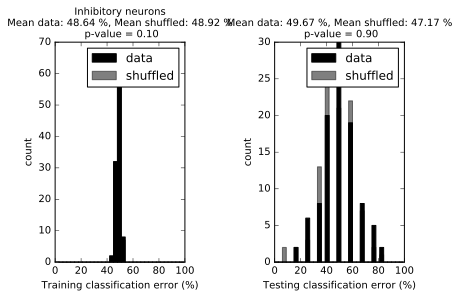

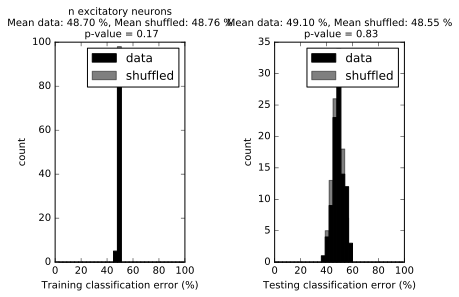

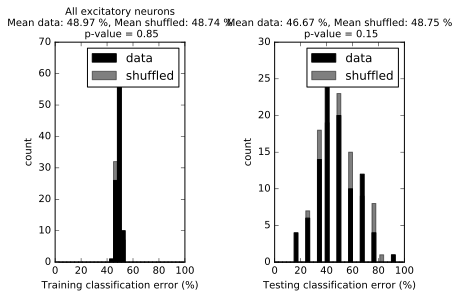

In [34]:
# Plot histograms of class error for training and testing datasets

if neuronType==2:
    
    # inh
    print 'All inhibitory neurons'
    pd = perClassErrorTrain_data_inh
    ps = perClassErrorTrain_shfl_inh
    pd0 = perClassErrorTest_data_inh
    ps0 = perClassErrorTest_shfl_inh
    pvalueTrain = ttest2(pd, ps, tail = 'left');
    pvalueTest = ttest2(pd0, ps0, tail = 'left');

    print '\tTraining error: Mean actual: %.2f%%, Mean shuffled: %.2f%%, p-value = %.2f' %(np.mean(pd), np.mean(ps), pvalueTrain)
    print '\tTesting error: Mean actual: %.2f%%, Mean shuffled: %.2f%%, p-value = %.2f' %(np.mean(pd0), np.mean(ps0), pvalueTest)


    # Plot the histograms
    if doPlots:
        binEvery = 3; # bin width

        plt.figure()
        plt.subplot(1,2,1)
        plt.hist(pd, np.arange(0,100,binEvery), color = 'k', label = 'data');
        plt.hist(ps, np.arange(0,100,binEvery), color = 'k', alpha=.5, label = 'shuffled');
        plt.xlabel('Training classification error (%)')
        plt.ylabel('count')
        plt.title('Inhibitory neurons\nMean data: %.2f %%, Mean shuffled: %.2f %%\n p-value = %.2f' %(np.mean(pd), np.mean(ps), pvalueTrain), fontsize = 10)
        plt.legend()

        plt.subplot(1,2,2)
        plt.hist(pd0, np.arange(0,100,binEvery), color = 'k', label = 'data');
        plt.hist(ps0, np.arange(0,100,binEvery), color = 'k', alpha=.5, label = 'shuffled');
        plt.legend()
        plt.xlabel('Testing classification error (%)')
        plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%\n p-value = %.2f' %(np.mean(pd0), np.mean(ps0), pvalueTest), fontsize = 10)
        plt.ylabel('count')
        plt.tight_layout(pad=0.4, w_pad=1.5, h_pad=1.0)





    # n exc    
    print 'Only n of the excitory neurons'
    pd = perClassErrorTrain_data_exc
    ps = perClassErrorTrain_shfl_exc
    pd0 = perClassErrorTest_data_exc
    ps0 = perClassErrorTest_shfl_exc
    pvalueTrain = ttest2(pd, ps, tail = 'left');
    pvalueTest = ttest2(pd0, ps0, tail = 'left');

    print '\tTraining error: Mean actual: %.2f%%, Mean shuffled: %.2f%%, p-value = %.2f' %(np.mean(pd), np.mean(ps), pvalueTrain)
    print '\tTesting error: Mean actual: %.2f%%, Mean shuffled: %.2f%%, p-value = %.2f' %(np.mean(pd0), np.mean(ps0), pvalueTest)


    # Plot the histograms
    if doPlots:
        binEvery = 3; # bin width

        plt.figure()
        plt.subplot(1,2,1)
        plt.hist(pd, np.arange(0,100,binEvery), color = 'k', label = 'data');
        plt.hist(ps, np.arange(0,100,binEvery), color = 'k', alpha=.5, label = 'shuffled');
        plt.xlabel('Training classification error (%)')
        plt.ylabel('count')
        plt.title('n excitatory neurons\nMean data: %.2f %%, Mean shuffled: %.2f %%\n p-value = %.2f' %(np.mean(pd), np.mean(ps), pvalueTrain), fontsize = 10)
        plt.legend()

        plt.subplot(1,2,2)
        plt.hist(pd0, np.arange(0,100,binEvery), color = 'k', label = 'data');
        plt.hist(ps0, np.arange(0,100,binEvery), color = 'k', alpha=.5, label = 'shuffled');
        plt.legend()
        plt.xlabel('Testing classification error (%)')
        plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%\n p-value = %.2f' %(np.mean(pd0), np.mean(ps0), pvalueTest), fontsize = 10)
        plt.ylabel('count')
        plt.tight_layout(pad=0.4, w_pad=1.5, h_pad=1.0)





    # all exc    
    print 'All excitatory neurons'
    pd = perClassErrorTrain_data_allExc
    ps = perClassErrorTrain_shfl_allExc
    pd0 = perClassErrorTest_data_allExc
    ps0 = perClassErrorTest_shfl_allExc
    pvalueTrain = ttest2(pd, ps, tail = 'left');
    pvalueTest = ttest2(pd0, ps0, tail = 'left');

    print '\tTraining error: Mean actual: %.2f%%, Mean shuffled: %.2f%%, p-value = %.2f' %(np.mean(pd), np.mean(ps), pvalueTrain)
    print '\tTesting error: Mean actual: %.2f%%, Mean shuffled: %.2f%%, p-value = %.2f' %(np.mean(pd0), np.mean(ps0), pvalueTest)


    # Plot the histograms
    if doPlots:
        binEvery = 3; # bin width

        plt.figure()
        plt.subplot(1,2,1)
        plt.hist(pd, np.arange(0,100,binEvery), color = 'k', label = 'data');
        plt.hist(ps, np.arange(0,100,binEvery), color = 'k', alpha=.5, label = 'shuffled');
        plt.xlabel('Training classification error (%)')
        plt.ylabel('count')
        plt.title('All excitatory neurons\nMean data: %.2f %%, Mean shuffled: %.2f %%\n p-value = %.2f' %(np.mean(pd), np.mean(ps), pvalueTrain), fontsize = 10)
        plt.legend()

        plt.subplot(1,2,2)
        plt.hist(pd0, np.arange(0,100,binEvery), color = 'k', label = 'data');
        plt.hist(ps0, np.arange(0,100,binEvery), color = 'k', alpha=.5, label = 'shuffled');
        plt.legend()
        plt.xlabel('Testing classification error (%)')
        plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%\n p-value = %.2f' %(np.mean(pd0), np.mean(ps0), pvalueTest), fontsize = 10)
        plt.ylabel('count')
        plt.tight_layout(pad=0.4, w_pad=1.5, h_pad=1.0)    

## Set correct classification traces for the following cases:
    
    1) All inhibitory neurons contribute to the decoder
    2) N excitatory neurons contribute, where n = number of inhibitory neurons. 
    3) All excitatory neurons contribute
    
    Using best c we fit the classifier to Xinh, Xexc, XallExc using all trials.

In [35]:
if neuronType==2:
    
    Xinh = X[:, inhRois==1]
    XallExc = X[:, inhRois==0]
    lenInh = (inhRois==1).sum()
    excI = np.argwhere(inhRois==0)  

    
    #%% Set correct classification traces for inh
    linear_svm_inh = copy.deepcopy(linear_svm_0)
    linear_svm_inh.fit(Xinh, Y)
    # w = np.squeeze(linear_svm.coef_);
    # b = linear_svm.intercept_;
    # trainE_inh = abs(linear_svm_inh.predict(Xinh)-Y.astype('float')).sum()/len(Y)*100;
    # trainE_inh

    tempInh = Xt[:,inhRois==1,:] # stimulus-aligned traces (I think you should use Xtsa for consistency... u get projections from Xtsa)
    temp = tempInh
    linear_svm_now = linear_svm_inh

    nnf, nnu, nnt = temp.shape
    corrClass_inh = np.ones((T, nnt)) + np.nan # frames x trials

    for t in range(T):
        trac = np.squeeze(temp[t, :, :]).T # trials x neurons  # stimulus-aligned trace at time t
        corrFract = 1 - abs(linear_svm_now.predict(trac)-choiceVecNow); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
        # corrFract = 1 - abs(linear_svm.predict(trac)-Y); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
        corrClass_inh[t,:] = corrFract # frames x trials % fraction correct classification for all trials
        # perClassCorr_t.append(corrFract.mean()*100) # average correct classification across trials for time point t. Same as np.mean(corrClass, axis=1)    

#     corrClass_inh = np.mean(corrClass2, axis = 1) # frames x 1. Average correct class across trials for each shuffle.





    #%% Set correct classification traces for all exc
    linear_svm_allExc = copy.deepcopy(linear_svm_0)
    linear_svm_allExc.fit(XallExc, Y)
    # w = np.squeeze(linear_svm.coef_);
    # b = linear_svm.intercept_;
    # trainE_allExc = abs(linear_svm_allExc.predict(XallExc)-Y.astype('float')).sum()/len(Y)*100;
    # trainE_allExc

    tempAllExc = Xt[:,inhRois==0,:] # stimulus-aligned traces (I think you should use Xtsa for consistency... u get projections from Xtsa)
    temp = tempAllExc
    linear_svm_now = linear_svm_allExc

    nnf, nnu, nnt = temp.shape
    corrClass_allExc = np.ones((T, nnt)) + np.nan # frames x trials

    for t in range(T):
        trac = np.squeeze(temp[t, :, :]).T # trials x neurons  # stimulus-aligned trace at time t
        corrFract = 1 - abs(linear_svm_now.predict(trac)-choiceVecNow); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
        # corrFract = 1 - abs(linear_svm.predict(trac)-Y); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
        corrClass_allExc[t,:] = corrFract # frames x trials % fraction correct classification for all trials
        # perClassCorr_t.append(corrFract.mean()*100) # average correct classification across trials for time point t. Same as np.mean(corrClass, axis=1)    

#     corrClass_allExc = np.mean(corrClass2, axis = 1) # frames x 1. Average correct class across trials for each shuffle.




    #%% Set correct classification traces for n exc
    numShufflesExc = 10 # we choose n random excitator neurons, how many times to do this?
    corrClass_exc = []
    for ii in range(numShufflesExc):            
        en = rng.permutation(excI)[0:lenInh].squeeze() # n randomly selected exc neurons.
        Xexc = X[:, en]

        linear_svm_exc = copy.deepcopy(linear_svm_0)
        linear_svm_exc.fit(Xexc, Y)
        # w = np.squeeze(linear_svm.coef_);
        # b = linear_svm.intercept_;
        # trainE_exc = abs(linear_svm_exc.predict(Xexc)-Y.astype('float')).sum()/len(Y)*100;
        # trainE_exc

        tempExc = Xt[:,en,:] # stimulus-aligned traces (I think you should use Xtsa for consistency... u get projections from Xtsa)
        temp = tempExc
        linear_svm_now = linear_svm_exc

        nnf, nnu, nnt = temp.shape
        corrClass2 = np.ones((T, nnt)) + np.nan # frames x trials

        for t in range(T):
            trac = np.squeeze(temp[t, :, :]).T # trials x neurons  # stimulus-aligned trace at time t
            corrFract = 1 - abs(linear_svm_now.predict(trac)-choiceVecNow); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
            # corrFract = 1 - abs(linear_svm.predict(trac)-Y); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
            corrClass2[t,:] = corrFract # frames x trials % fraction correct classification for all trials
            # perClassCorr_t.append(corrFract.mean()*100) # average correct classification across trials for time point t. Same as np.mean(corrClass, axis=1)    

        corrClass_exc.append(corrClass2) # numShuffExc x frames x trials. Average correct class across trials for each shuffle.           
    s1, s2, s3 = np.shape(corrClass_exc)
    a = np.reshape(np.transpose(corrClass_exc, (1,0,2)), (s2,s1*s3), order = 'F') # frames x (numShuffExc x trials)
    corrClass_exc = a
    
#         corrClass_exc.append(np.mean(corrClass2, axis = 1)) # numShuffExc x frames. Average correct class across trials for each shuffle.    
#     corrClass_exc = np.transpose(corrClass_exc) # frames x numShuffExc


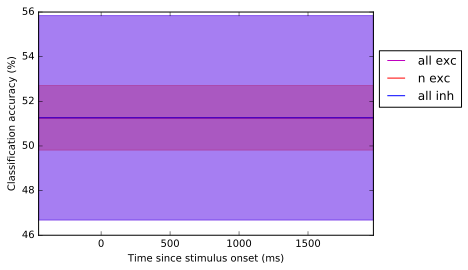

In [36]:
# Plot correct classification traces for the following cases:
#     1) All inhibitory neurons contribute to the decoder
#     2) N excitatory neurons contribute, where n = number of inhibitory neurons. 
#     3) All excitatory neurons contribute
    
if doPlots and neuronType==2:
    
    plt.figure()   
#     plt.subplot(1,2,1)
    
    # Plot corrClass for all excitatory neurons
    a1 = np.mean(corrClass_allExc, axis=1)*100
    s1 = np.std(corrClass_allExc, axis=1)*100 /np.sqrt(corrClass_allExc.shape[1])    
    
    plt.fill_between(time_aligned_stim, a1-s1, a1+s1, alpha=0.3, edgecolor='m', facecolor='m')
    plt.plot(time_aligned_stim, a1, 'm', label = 'all exc')
    plt.xlabel('Time since stimulus onset (ms)')
#     plt.ylabel('Classification accuracy (%)')    
    plt.ylabel('Classification accuracy (%)')    
    plt.xlim([time_aligned_stim[0], time_aligned_stim[-1]])
    
    
    
    # Plot corrClass for n excitatory neurons
    a1 = np.mean(corrClass_exc, axis=1)*100
    s1 = np.std(corrClass_exc, axis=1)*100 /np.sqrt(corrClass_exc.shape[1])    
    
    plt.fill_between(time_aligned_stim, a1-s1, a1+s1, alpha=0.3, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_stim, a1, 'r', label = 'n exc')
    plt.xlabel('Time since stimulus onset (ms)')
#     plt.ylabel('Classification accuracy (%)')    
    plt.ylabel('Classification accuracy (%)')    
    plt.xlim([time_aligned_stim[0], time_aligned_stim[-1]])
    
    
    
    # Plot corrClass for all inhibitory neurons
    a1 = np.mean(corrClass_inh, axis=1)*100
    s1 = np.std(corrClass_inh, axis=1)*100 /np.sqrt(corrClass_inh.shape[1])    
    
    plt.fill_between(time_aligned_stim, a1-s1, a1+s1, alpha=0.3, edgecolor='b', facecolor='b')
    plt.plot(time_aligned_stim, a1, 'b', label = 'all inh')
    plt.xlabel('Time since stimulus onset (ms)')
#     plt.ylabel('Classification accuracy (%)')    
    plt.ylabel('Classification accuracy (%)')    
    plt.xlim([time_aligned_stim[0], time_aligned_stim[-1]])
    
    plt.legend(loc='center left', bbox_to_anchor=(1, .7))

### Alternative way of doing the analysis above: compare prediction error when setting weights of excitatory neurons to 0 with when setting weights of inhibitory neurons to 0
    When setting weights of excit neurons to 0, we only do it for n excit neurons, where n = number of inhibitory neurons. This is to  control for the difference in the number of excit and inhibit neurons.
    

/home/farznaj/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/farznaj/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Training error: 
inh set to 0 = 48.74%
excit set to 0 (mean of 100 rounds)) = 48.74%
all exc set to 0 = 48.74%
p_val(train_err_exc0: excit vs inhibit set to 0) = nan

Training error, change relative to original: 
inh set to 0 = 0.00
excit set to 0 (mean of 100 rounds)) = 0.00
p_val(train_err_exc0: excit vs inhibit set to 0) = nan


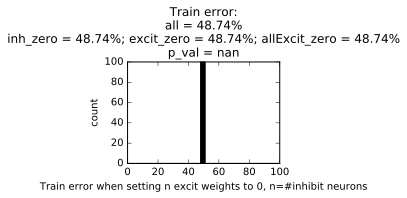

In [37]:
if neuronType==2:
    
    # compute prediction error when all neurons are included.
    linear_svm = copy.deepcopy(linear_svm_0)
    trainE = abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100;
    
    
    # compute prediction error when setting weights of n excitatory neurons to 0, where n = number of inhibitory neurons
    
    numShuffles = 100
    lenInh = (inhRois==1).sum()
    train_err_exc0 = []    
    excI = np.argwhere(inhRois==0)    

    corrClass_exc0 = np.full([Xt.shape[0], numShuffles], np.nan) # frames x numShuffles. Average correct class across trials for each shuffle when exc weights are set to 0.
    
    for i in range(numShuffles):
        # linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l1', dual=False)
        # linear_svm.fit(X, Y)  
        # ww = np.squeeze(linear_svm.coef_);
        ww = w+0; # adding 0 is important, otherwise, ww=w will change the value of w as well.
        
        # set weights of random sets of excit neurons (of size equal to length of inhibit neurons) to 0.
        en = rng.permutation(excI)[0:lenInh].squeeze()
        ww[en] = 0

        linear_svm = copy.deepcopy(linear_svm_0)
        linear_svm.coef_ = ww.reshape(1,-1) # here weights of random sets of excit neurons are set to 0 (of size equal to length of inhibit neurons)

        # print 'Training error: %.2f %%' %(abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100)
        train_err_exc0.append(abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100)


        # Set correct classification traces
        temp = Xt # stimulus aligned traces (I think you should use Xtsa for consistency... u get projections from Xtsa)
        nnf, nnu, nnt = temp.shape
        corrClass2 = np.ones((T, nnt)) + np.nan # frames x trials
        # if trs4project!='trained':  # onlyTrainedTrs==0: 
        #     temp = temp[:,:,~trsExcluded] # make sure it has same size as Y, you need this for svm.predict below. 
        for t in range(T):
            trac = np.squeeze(temp[t, :, :]).T # trials x neurons  # stimulus-aligned trace at time t
            corrFract = 1 - abs(linear_svm.predict(trac)-choiceVecNow); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
            # corrFract = 1 - abs(linear_svm.predict(trac)-Y); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
            corrClass2[t,:] = corrFract # frames x trials % fraction correct classification for all trials
            # perClassCorr_t.append(corrFract.mean()*100) # average correct classification across trials for time point t. Same as np.mean(corrClass, axis=1)    
        
        corrClass_exc0[:,i] = np.mean(corrClass2, axis = 1) # frames x numShuffles. Average correct class across trials for each shuffle.
        

    # Fraction of change in training error after setting weights of n exc neurons to 0 (n = num inh neurons)   
    train_err_exc0_rel2all = (train_err_exc0 - trainE) / trainE    
        

        
        
    #%% set weights of all excit Ns to 0
    ww = w+0;    
    ww[inhRois==0] = 0 
    linear_svm = copy.deepcopy(linear_svm_0)
    linear_svm.coef_ = ww.reshape(1,-1)
    train_err_allExc0 = abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100
    

    # Set correct classification traces
    temp = Xt # stimulus aligned traces (I think you should use Xtsa for consistency... u get projections from Xtsa)
    nnf, nnu, nnt = temp.shape
    corrClass2 = np.ones((T, nnt)) + np.nan # frames x trials
    # if trs4project!='trained':  # onlyTrainedTrs==0: 
    #     temp = temp[:,:,~trsExcluded] # make sure it has same size as Y, you need this for svm.predict below. 
    for t in range(T):
        trac = np.squeeze(temp[t, :, :]).T # trials x neurons  # stimulus-aligned trace at time t
        corrFract = 1 - abs(linear_svm.predict(trac)-choiceVecNow); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
        # corrFract = 1 - abs(linear_svm.predict(trac)-Y); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
        corrClass2[t,:] = corrFract # frames x trials % fraction correct classification for all trials
        # perClassCorr_t.append(corrFract.mean()*100) # average correct classification across trials for time point t. Same as np.mean(corrClass, axis=1)    

    corrClass_allExc0 = np.mean(corrClass2, axis = 1) # frames x 1. Average correct class across trials for each shuffle.
    corrClass_allExc0 = corrClass_allExc0[:,np.newaxis] # so it has size (frames x 1)
    
    
    
    
    
    #%% compute prediction error when setting weights of inhibitory neurons to 0
    numShufflesI = 1; # bc we use all inh neurons (ie no random selection), we don't need to run it multiple times.
    train_err_inh0 = []    
    inhI = np.argwhere(inhRois==1)    

    corrClass_inh0 = np.full([Xt.shape[0], numShufflesI], np.nan) # frames x numShuffles. Average correct class across trials for each shuffle when exc weights are set to 0.
    
    for i in range(numShufflesI):
        # linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l1', dual=False)
        # linear_svm.fit(X, Y)  
        # ww = np.squeeze(linear_svm.coef_);
        ww = w+0; # adding 0 is important, otherwise, ww=w will change the value of w as well.
        
        # set weights of random sets of excit neurons (of size equal to length of inhibit neurons) to 0.
        en = rng.permutation(inhI).squeeze()
        ww[en] = 0

        linear_svm = copy.deepcopy(linear_svm_0) # we need to do this bc we changes its coef_ above
        linear_svm.coef_ = ww.reshape(1,-1) # here weights of random sets of excit neurons are set to 0 (of size equal to length of inhibit neurons)

        # print 'Training error: %.2f %%' %(abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100)
        train_err_inh0.append(abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100)


        # Set correct classification traces
        temp = Xt # stimulus aligned traces (I think you should use Xtsa for consistency... u get projections from Xtsa)
        nnf, nnu, nnt = temp.shape
        corrClass2 = np.ones((T, nnt)) + np.nan # frames x trials
        # if trs4project!='trained':  # onlyTrainedTrs==0: 
        #     temp = temp[:,:,~trsExcluded] # make sure it has same size as Y, you need this for svm.predict below. 
        for t in range(T):
            trac = np.squeeze(temp[t, :, :]).T # trials x neurons  # stimulus-aligned trace at time t
            corrFract = 1 - abs(linear_svm.predict(trac)-choiceVecNow); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
            # corrFract = 1 - abs(linear_svm.predict(trac)-Y); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
            corrClass2[t,:] = corrFract # frames x trials % fraction correct classification for all trials
            # perClassCorr_t.append(corrFract.mean()*100) # average correct classification across trials for time point t. Same as np.mean(corrClass, axis=1)    
        
        corrClass_inh0[:,i] = np.mean(corrClass2, axis = 1) # frames x numShuffles. Average correct class across trials for each shuffle.
        
        
        # Fraction of change in training error after setting weights of n exc neurons to 0 (n = num inh neurons)   
        train_err_inh0_rel2all = (train_err_inh0 - trainE) / trainE
        

    linear_svm = copy.deepcopy(linear_svm_0) # go back to the original value
        
    '''
    # linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l1', dual=False)
    # linear_svm.fit(X, Y)  
    # ww = np.squeeze(linear_svm.coef_);
    ww = w+0;    
    ww[inhRois==1] = 0 # set weights of inhibit Ns to 0
    
    linear_svm = copy.deepcopy(linear_svm_0) # we need to do this bc we changes its coef_ above
    linear_svm.coef_ = ww.reshape(1,-1) # here weights of inh neurons are set to 0.
    
    train_err_inh0 = abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100
        
    # Fraction of change in training error after setting weights of inh neurons to 0
    train_err_inh0_rel2all = (train_err_inh0 - trainE) / trainE   
    

    
    # Set correct classification traces
    temp = Xt # stimulus aligned traces (I think you should use Xtsa for consistency... u get projections from Xtsa)
    nnf, nnu, nnt = temp.shape
    corrClass = np.ones((T, nnt)) + np.nan # frames x trials

    # if trs4project!='trained':  # onlyTrainedTrs==0: 
    #     temp = temp[:,:,~trsExcluded] # make sure it has same size as Y, you need this for svm.predict below. 
    for t in range(T):
        trac = np.squeeze(temp[t, :, :]).T # trials x neurons  # stimulus-aligned trace at time t
        corrFract = 1 - abs(linear_svm.predict(trac)-choiceVecNow); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
        # corrFract = 1 - abs(linear_svm.predict(trac)-Y); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
        corrClass[t,:] = corrFract # frames x trials % fraction correct classification for all trials
        # perClassCorr_t.append(corrFract.mean()*100) # average correct classification across trials for time point t. Same as np.mean(corrClass, axis=1)    

    corrClass_inh0 = np.mean(corrClass, axis = 1) # frames x 1. Average correct class across trials for each shuffle when inh weights are set to 0.
    corrClass_inh0_std = np.std(corrClass, axis = 1)
    '''
    
    
    
    #%% P value of fraction changes in training error for exc vs inh weights set to 0. (not sure if better to do it on fraction changes or on the actual training errors?!)
#     h, p = stats.ttest_1samp(train_err_exc0_rel2all, train_err_inh0_rel2all)        
    h, p = stats.ttest_ind(train_err_exc0, train_err_inh0)        
    print '\nTraining error: \ninh set to 0 = %.2f%%\nexcit set to 0 (mean of 100 rounds)) = %.2f%%\nall exc set to 0 = %.2f%%\np_val(train_err_exc0: excit vs inhibit set to 0) = %.2f' %(np.mean(train_err_inh0), np.mean(train_err_exc0), np.mean(train_err_allExc0), p)
    print '\nTraining error, change relative to original: \ninh set to 0 = %.2f\nexcit set to 0 (mean of 100 rounds)) = %.2f\np_val(train_err_exc0: excit vs inhibit set to 0) = %.2f' %(np.mean(train_err_inh0_rel2all), np.mean(train_err_exc0_rel2all), p)

    
    #%% plot the distribution of training error for when random sets of excit weights are set to 0.
    if doPlots:
        plt.figure()
        plt.subplot(2,2,1)
        plt.hist(train_err_exc0, np.arange(0,100,3), color = 'k', label = 'data');
        plt.xlabel('Train error when setting n excit weights to 0, n=#inhibit neurons')
        plt.ylabel('count')
        plt.title('Train error:\nall = %.2f%%\ninh_zero = %.2f%%; excit_zero = %.2f%%; allExcit_zero = %.2f%%\np_val = %.2f' %(trainE, np.mean(train_err_inh0), np.mean(train_err_exc0), np.mean(train_err_allExc0), p))
        plt.tight_layout#(pad=0.4, w_pad=1.5, h_pad=1.0)
    


NameError: name 'corrClass_allExc0' is not defined

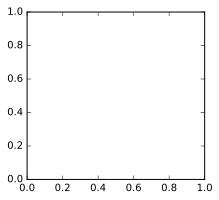

In [248]:
# Plot changes in class accuracy after setting exc w or inh w to 0 (relative to the original class accuracy).

if doPlots and neuronType==2:
    plt.figure(figsize=(7,3))
    
    # Compare correct classification traces for when inhibitory weights are set to 0 to when excitatory weights are set to 0.
    plt.subplot(1,2,1)    


    # Plot corrClass for when all excitatory neurons are set to 0
    #     a1 = np.mean(corrClass_exc0, axis=1)*100 - a0
    #     s1 = np.std(corrClass_exc0, axis=1)*100 #/np.sqrt(corrClass_exc0.shape[1])    
    a1 = np.mean(corrClass_allExc0, axis=1)*100
    s1 = np.std(corrClass_allExc0, axis=1)*100 #/np.sqrt(corrClass_exc0.shape[1])    

    plt.fill_between(time_aligned_stim, a1-s1, a1+s1, alpha=0.3, edgecolor='m', facecolor='m')
    plt.plot(time_aligned_stim, a1, 'm', label = 'all exc w set to 0')
    plt.xlabel('Time since stimulus onset (ms)')



    # Plot corrClass for when excitatory neurons are set to 0
    a = np.mean(corrClass_exc0, axis=1)*100 
    s = np.std(corrClass_exc0, axis=1)*100 #/np.sqrt(corrClass_exc0.shape[1])    

    plt.fill_between(time_aligned_stim, a-s, a+s, alpha=0.5, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_stim, a, 'r', label = 'exc w set to 0')
    plt.xlabel('Time since stimulus onset (ms)')
    plt.ylabel('Classification accuracy (%)')    
    plt.xlim([time_aligned_stim[0], time_aligned_stim[-1]])


    # Plot corrClass for when inhibitory neurons are set to 0
    #     a = corrClass_inh0*100 
    #     s = corrClass_inh0_std*100 /np.sqrt(corrClass.shape[1])
    a = np.mean(corrClass_inh0, axis=1)*100 
    s = np.std(corrClass_inh0, axis=1)*100 #/np.sqrt(corrClass_exc0.shape[1])  
    plt.fill_between(time_aligned_stim, a-s, a+s, alpha=0.5, edgecolor='b', facecolor='b')
    plt.plot(time_aligned_stim, a, 'b', label = 'inh w set to 0')

#     plt.legend(loc='center left', bbox_to_anchor=(1, .7))


    # Plot original corrClass
    a = np.mean(corrClass, axis=1)*100 
    s = np.std(corrClass, axis=1)*100 /np.sqrt(numTrials);
    #     plt.figure()
    #     plt.subplot(1,2,1)
    #     plt.fill_between(time_aligned_stim, a-s, a+s, alpha=0.5, edgecolor='g', facecolor='g')
    plt.plot(time_aligned_stim, a, 'g', label='original')
    plt.xlabel('time since stimulus onset (ms)')
    plt.ylabel('classification accuracy (%)')

    plt.xlim([time_aligned_stim[0], time_aligned_stim[-1]])



    
    plt.subplot(1,2,2)        
    
    # Plot corrClass for all weights    
    a0 = np.mean(corrClass, axis=1)*100 
    '''
    s0 = np.std(corrClass, axis=1)*100 /np.sqrt(numTrials);
#     plt.figure()
#     plt.subplot(1,2,1)
    plt.fill_between(time_aligned_stim, a0-s0, a0+s0, alpha=0.3, edgecolor='g', facecolor='g')
    plt.plot(time_aligned_stim, a0, 'g', label = 'original')
    plt.xlabel('time since stimulus onset (ms)')
    plt.ylabel('classification accuracy (%)')
    plt.xlim([time_aligned_stim[0], time_aligned_stim[-1]])
    '''        
    plt.plot(time_aligned_stim, np.zeros((np.shape(time_aligned_stim))), 'g') 
    
    
    # Plot corrClass for when all excitatory neurons are set to 0
#     a1 = np.mean(corrClass_exc0, axis=1)*100 - a0
#     s1 = np.std(corrClass_exc0, axis=1)*100 #/np.sqrt(corrClass_exc0.shape[1])    
    a1 = np.mean(corrClass_allExc0, axis=1)*100 - a0
    s1 = np.std(corrClass_allExc0, axis=1)*100 #/np.sqrt(corrClass_exc0.shape[1])    
    
    plt.fill_between(time_aligned_stim, a1-s1, a1+s1, alpha=0.3, edgecolor='m', facecolor='m')
    plt.plot(time_aligned_stim, a1, 'm', label = 'all exc w set to 0')
    plt.xlabel('Time since stimulus onset (ms)')
#     plt.ylabel('Classification accuracy (%)')    
#     plt.ylabel('Change in classification accuracy (%)')    
#     plt.xlim([time_aligned_stim[0], time_aligned_stim[-1]])
    
    
    # Plot corrClass for when n excitatory neurons are set to 0
    a1 = np.mean(corrClass_exc0, axis=1)*100 - a0
    s1 = np.std(corrClass_exc0, axis=1)*100 #/np.sqrt(corrClass_exc0.shape[1])    
    
    plt.fill_between(time_aligned_stim, a1-s1, a1+s1, alpha=0.3, edgecolor='r', facecolor='r')
    plt.plot(time_aligned_stim, a1, 'r', label = 'n exc w set to 0')
    plt.xlabel('Time since stimulus onset (ms)')
#     plt.ylabel('Classification accuracy (%)')    
    plt.ylabel('Change in classification accuracy (%)')    
    plt.xlim([time_aligned_stim[0], time_aligned_stim[-1]])
    
    
    # Plot corrClass for when inhibitory neurons are set to 0
#     a = corrClass_inh0*100 
#     s = corrClass_inh0_std*100 /np.sqrt(corrClass.shape[1])
    a2 = np.mean(corrClass_inh0, axis=1)*100 - a0
    s2 = np.std(corrClass_inh0, axis=1)*100 #/np.sqrt(corrClass_exc0.shape[1])  
    plt.fill_between(time_aligned_stim, a2-s2, a2+s2, alpha=0.3, edgecolor='b', facecolor='b')
    plt.plot(time_aligned_stim, a2, 'b', label = 'inh w set to 0')
    
    plt.legend(loc='center left', bbox_to_anchor=(1, .7))
#     plt.tight_layout()
    plt.subplots_adjust(wspace=.5)
    

## Excitatory and Inhibitory Neurons Relative Contribution to the decoder

We quantify the contribution of excitatory and inhibitory neurons to the encoding of the choice by measuring participation percentage, defined as the percentatge of a given population of neurons that has non-zero weights. We produce paraticipation curves, participation ratio at different values of svm regularizer (c), for each data

In [292]:
# This function finds the SVM decoder that predicts choices given responses in X by 
# using different values for c. At each value of c, it computes fraction of non-zero weights
# for exc and inh neurons, separately (perActive_inh, perActive_exc). Also it computes the 
# classification error (perClassEr) at each value of c. 
# Outputs: perActive_inh, perActive_exc, perClassEr, cvect_

def inh_exc_classContribution(X, Y, isinh): 
    import numpy as np
    from sklearn import svm
    
    def perClassError(Y, Yhat):
        import numpy as np
        perClassEr = sum(abs(np.squeeze(Yhat).astype(float)-np.squeeze(Y).astype(float)))/len(Y)*100
        return perClassEr
    
    Y = np.squeeze(Y); # class labels
    
    eps = 10**-10 # tiny number below which weight is considered 0
    isinh = isinh>0;  # vector of size number of neurons (1: neuron is inhibitory, 0: neuron is excitatoey); here I am making sure to convert it to logical
    n_inh = sum(isinh);
    n_exc = sum(~ isinh);
#     cvect_ = 10**(np.arange(-4, 6,0.1))/len(Y);
    cvect_ = 10**(np.arange(-6.5, 3.5, 0.1)) # FN: use this if you want the same cvect for all days
    perClassEr = [];
    perActive_inh = [];
    perActive_exc = [];
    w_allc = []
    for i in range(len(cvect_)): # At each value of cvect we compute the fraction of non-zero weights for excit and inhibit neurons.
        linear_svm = [];
        linear_svm = svm.LinearSVC(C = cvect_[i], loss='squared_hinge', penalty='l1', dual=False);
        linear_svm.fit(X, Y);
        w = np.squeeze(linear_svm.coef_);
        
        perActive_inh.append(sum(abs(w[isinh])>eps)/ (n_inh + 0.) * 100.)
        perActive_exc.append(sum(abs(w[~isinh])>eps)/ (n_exc + 0.) * 100.)
        w_allc.append(w) # includes weights of all neurons for each value of c
        perClassEr.append(perClassError(Y, linear_svm.predict(X)));
    
    return perActive_inh, perActive_exc, perClassEr, cvect_, w_allc


In [293]:
if neuronType==2:
    perActive_inh_allExc, perActive_exc_allExc, perClassEr_allExc, cvect_, wei_all_allExc = inh_exc_classContribution(X[:, ~np.isnan(inhRois)], Y, inhRois[~np.isnan(inhRois)])

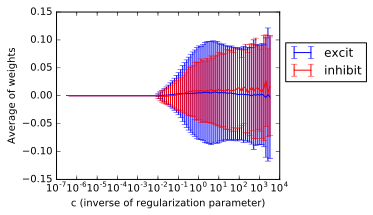

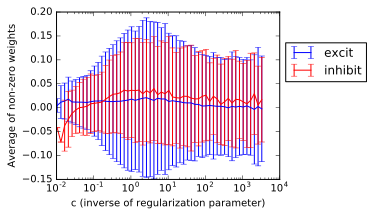

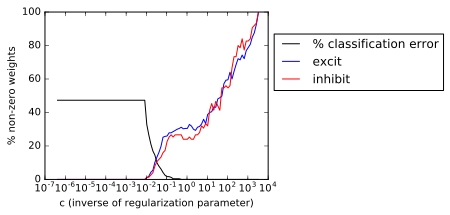

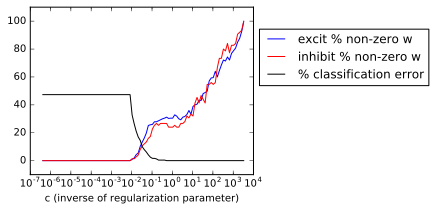

In [308]:
# Plot average of all weights, average of non-zero weights, and percentage of non-zero weights for each value of c
# Training the classifier using all exc and inh neurons at different values of c.

if doPlots and neuronType==2:    
    wei_all_allExc = np.array(wei_all_allExc)
    # plot ave across neurons for each value of c
    inhRois_allExc = inhRois[~np.isnan(inhRois)]
    
    
    ########
    # average and std of weights across neurons
    plt.figure(figsize=(4,3))
    plt.errorbar(cvect_, np.mean(wei_all_allExc[:,inhRois_allExc==0],axis=1), np.std(wei_all_allExc[:,inhRois_allExc==0],axis=1), color='b', label='excit')
    plt.errorbar(cvect_, np.mean(wei_all_allExc[:,inhRois_allExc==1],axis=1), np.std(wei_all_allExc[:,inhRois_allExc==1],axis=1), color='r', label='inhibit')
    plt.xscale('log')
    plt.xlabel('c (inverse of regularization parameter)')
#     plt.ylim([-10,110])
    plt.legend(loc='center left', bbox_to_anchor=(1, .7))
    plt.ylabel('Average of weights')
    
    
    ########
    # Average and std of non-zero weights across neurons
    wei_all_0inds = np.array([x==0 for x in wei_all_allExc]) # inds of zero weights
    wei_all_non0 = wei_all_allExc+0
    wei_all_non0[wei_all_0inds] = np.nan # set 0 weights to nan
    
    plt.figure(figsize=(4,3))
    plt.errorbar(cvect_, np.nanmean(wei_all_non0[:,inhRois_allExc==0],axis=1), np.nanstd(wei_all_non0[:,inhRois_allExc==0],axis=1), color='b', label='excit')
    plt.errorbar(cvect_, np.nanmean(wei_all_non0[:,inhRois_allExc==1],axis=1), np.nanstd(wei_all_non0[:,inhRois_allExc==1],axis=1), color='r', label='inhibit')
    plt.xscale('log')
    plt.xlabel('c (inverse of regularization parameter)')
#     plt.ylim([-10,110])
    plt.legend(loc='center left', bbox_to_anchor=(1, .7))
    plt.ylabel('Average of non-zero weights')
    
    
    ########
    # Percentage of non-zero weights
    wei_all_0inds = np.array([x==0 for x in wei_all_allExc]) # inds of zero weights
#     percNonZero_e = np.mean(wei_all_0inds[:,inhRois_ei==0]==0, axis=1) # fraction of nonzero weights per round and per c
#     percNonZero_i = np.mean(wei_all_0inds[:,inhRois_ei==1]==0, axis=1)
        
    plt.figure(figsize=(4,3))
    plt.plot(cvect_, perClassEr_allExc, 'k-', label = '% classification error')
    plt.plot(cvect_, 100*np.nanmean(wei_all_0inds[:,inhRois_allExc==0]==0,axis=1), color='b', label='excit')
    plt.plot(cvect_, 100*np.nanmean(wei_all_0inds[:,inhRois_allExc==1]==0,axis=1), color='r', label='inhibit')    
#     plt.errorbar(cvect_, np.nanmean(wei_all_0inds[:,inhRois_allExc==0]==0,axis=1), np.nanstd(wei_all_0inds[:,inhRois_allExc==0],axis=1), color='b', label='excit')
#     plt.errorbar(cvect_, np.nanmean(wei_all_0inds[:,inhRois_allExc==1]==0,axis=1), np.nanstd(wei_all_0inds[:,inhRois_allExc==1],axis=1), color='r', label='inhibit')
    plt.xscale('log')
    plt.xlabel('c (inverse of regularization parameter)')
#     plt.ylim([-10,110])
    plt.legend(loc='center left', bbox_to_anchor=(1, .7))
    plt.ylabel('% non-zero weights')
    
    '''
#     if doPlots and neuronType==2:    
    plt.figure(figsize=(4,3))
#     plt.subplot(221)
    plt.plot(cvect_, perActive_exc_allExc, 'b-', label = 'excit % non-zero w')
    plt.plot(cvect_, perActive_inh_allExc, 'r-', label = 'inhibit % non-zero w')
    plt.plot(cvect_, perClassEr_allExc, 'k-', label = '% classification error')
    plt.xscale('log')
    plt.xlabel('c (inverse of regularization parameter)')
    plt.ylim([-10,110])
    plt.legend(loc='center left', bbox_to_anchor=(1, .7))
    '''

 ### Another version of the analysis: equal number of exc and inh neurons
 We control for the different numbers of excitatory and inhibitory neurons by subsampling n excitatory neurons, where n is equal to the number of inhibitory neurons. More specifically, instead of sending the entire X to the function inh_exc_classContribution, we use a subset of X that includes equal number of exc and inh neurons (Exc neurons are randomly selected).

In [315]:
# Use equal number of exc and inh neurons
if neuronType==2 and np.sum(w)!=0:
    X_ = X[:, ~np.isnan(inhRois)];
    inhRois_ = inhRois[~np.isnan(inhRois)].astype('int32')
    ix_i = np.argwhere(inhRois_).squeeze()
    ix_e = np.argwhere(inhRois_-1).squeeze()
    n = len(ix_i);
    Xei = np.zeros((len(Y), 2*n));
    inhRois_ei = np.zeros((2*n));
    perActive_inh = [];
    perActive_exc = [];
    perClassEr = [];
    wei_all = []
    for i in range(numSamples):
        msk = rng.permutation(ix_e)[0:n];
        Xei[:, 0:n] = X_[:, msk]; # first n columns are X of random excit neurons.
        inhRois_ei[0:n] = 0;

        Xei[:, n:2*n] = X_[:, ix_i]; # second n icolumns are X of inhibit neurons.
        inhRois_ei[n:2*n] = 1;
        # below we fit svm onto Xei, which for all shuffles (numSamples) has the same set of inh neurons but different sets of exc neurons
        ai, ae, ce, cvect_, wei = inh_exc_classContribution(Xei, Y, inhRois_ei); # ai is of length cvect defined in inh_exc_classContribution
        perActive_inh.append(ai); # numSamples x length(cvect_)
        perActive_exc.append(ae);
        wei_all.append(wei) # numSamples x length(cvect_) x numNeurons(inh+exc equal numbers)
        perClassEr.append(ce);       
            


p value (pooled for all values of c):
exc ~= inh : 0.80
exc < inh : 0.40
exc > inh : 0.60


/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:71: RuntimeWarning: invalid value encountered in less
/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in less
/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in less


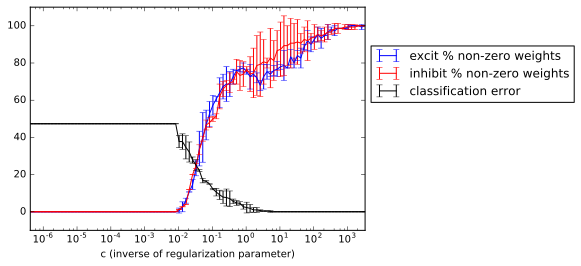

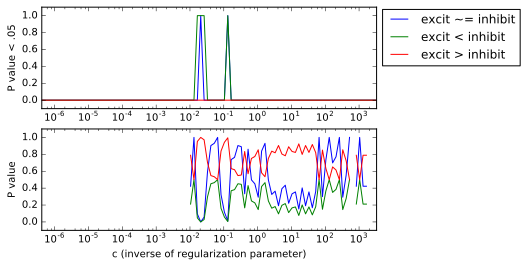

In [285]:
if neuronType==2 and np.sum(w)!=0:
    
    # p value of comparing exc and inh non-zero weights pooled across values of c :
    aa = np.array(perActive_exc).flatten()
#     aa = aa[np.logical_and(aa>0 , aa<100)]
    # np.shape(aa)

    bb = np.array(perActive_inh).flatten()
#     bb = bb[np.logical_and(bb>0 , bb<100)]
    # np.shape(bb)

    h, p_two = stats.ttest_ind(aa, bb)
    p_tl = ttest2(aa, bb, tail='left')
    p_tr = ttest2(aa, bb, tail='right')
    print '\np value (pooled for all values of c):\nexc ~= inh : %.2f\nexc < inh : %.2f\nexc > inh : %.2f' %(p_two, p_tl, p_tr)


    # two-tailed p-value
    h, p_two = stats.ttest_ind(np.array(perActive_exc), np.array(perActive_inh))
    # left-tailed p-value : excit < inhibit
    p_tl = ttest2(np.array(perActive_exc), np.array(perActive_inh), tail='left')
    # right-tailed p-value : excit > inhibit
    p_tr = ttest2(np.array(perActive_exc), np.array(perActive_inh), tail='right')
    
    
    
    # Plot the c path :
    if doPlots:
        plt.figure(figsize=(4,3)) 
        plt.errorbar(cvect_, np.mean(np.array(perActive_exc), axis=0), yerr=2*np.std(np.array(perActive_exc), axis=0), color = 'b', label = 'excit % non-zero weights')
        plt.errorbar(cvect_, np.mean(np.array(perActive_inh), axis=0), yerr=2*np.std(np.array(perActive_inh), axis=0), color = 'r', label = 'inhibit % non-zero weights')
        plt.xscale('log')
        plt.ylim([-10,110])
        # plt.ylabel('% non-zero weights')
        # plt.legend(loc='center left', bbox_to_anchor=(1, .7))
        plt.xlim([cvect_[0], cvect_[-1]])

        # plt.plot(cvect_, p_two, label = 'excit ~= inhibit')
        # plt.plot(cvect_, p_tl, label = 'excit < inhibit')
        # plt.plot(cvect_, p_tr, label = 'inhibit < excit')


        # plt.figure()
        plt.errorbar(cvect_ ,np.mean(np.array(perClassEr), axis=0), yerr=2*np.std(np.array(perClassEr), axis=0), color = 'k', label = 'classification error') # range(len(perClassEr[0]))
        plt.ylim([-10,110])
        plt.xscale('log')
        plt.xlabel('c (inverse of regularization parameter)')
        # plt.ylabel('classification error')
        plt.xlim([cvect_[0], cvect_[-1]])
        plt.legend(loc='center left', bbox_to_anchor=(1, .7))
        # plt.tight_layout()


        plt.figure(figsize=(4,3))
        plt.subplot(212)
        # plt.plot(cvect_, p_two<.05, label = 'excit ~= inhibit')
        # plt.plot(cvect_, p_tl<.05, label = 'excit < inhibit')
        # plt.plot(cvect_, p_tr<.05, label = 'inhibit < excit')
        plt.plot(cvect_, p_two, label = 'excit ~= inhibit')
        plt.plot(cvect_, p_tl, label = 'excit < inhibit')
        plt.plot(cvect_, p_tr, label = 'inhibit < excit')
        plt.xscale('log')
        plt.ylim([-.1, 1.1])
        # plt.legend(loc='center left', bbox_to_anchor=(1, .7))
        plt.ylabel('P value')
        plt.xlim([cvect_[0], cvect_[-1]])
        plt.xlabel('c (inverse of regularization parameter)')

        # plt.figure()
        plt.subplot(211)
        plt.plot(cvect_, p_two<.05, label = 'excit ~= inhibit')
        plt.plot(cvect_, p_tl<.05, label = 'excit < inhibit')
        plt.plot(cvect_, p_tr<.05, label = 'excit > inhibit')
        plt.xscale('log')
        plt.ylim([-.1, 1.1])
        plt.xlim([cvect_[0], cvect_[-1]])
        plt.ylabel('P value < .05')
        plt.legend(loc='center left', bbox_to_anchor=(1, .7))

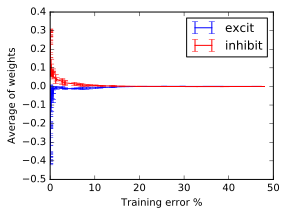

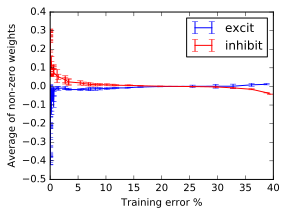

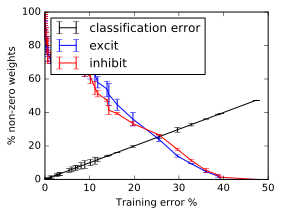

In [319]:
# Plot average of all weights, average of non-zero weights, and percentage of non-zero weights for each value of c
# Training the classifier using all exc and inh neurons at different values of c.

if doPlots and neuronType==2 and np.sum(w)!=0:
    
    xaxisErr = 0; # if 1 x axis will be training error, otherwise it will be c.
    
    wei_all = np.array(wei_all)
    
    ########
    # average of weights    

    # Average weights of all neurons for each value of c. Then plot average and std across rounds for each value of c.

    # exc
    wave = np.mean(wei_all[:,:,inhRois_ei==0], axis=2) # average of all neural weights per c value and per round
    ave = np.mean(wave, axis=0) # average of weights across rounds
    sde = np.std(wave, axis=0) # std of weights across rounds

    # inh
    wavi = np.mean(wei_all[:,:,inhRois_ei==1], axis=2) # average of all neural weights per c value and per round
    avi = np.mean(wavi, axis=0) # average of weights across rounds
    sdi = np.std(wavi, axis=0) # std of weights across rounds


    aveEr = np.mean(np.array(perClassEr), axis=0)
    if xaxisErr:
        x = aveEr
    else:
        x = cvect_
        
    plt.figure(figsize=(4,3))
    plt.errorbar(x, ave, sde, color = 'b', label = 'excit')
    plt.errorbar(x, avi, sdi, color = 'r', label = 'inhibit')
    
    if xaxisErr:
        plt.xlabel('Training error %')
    else:
        plt.xscale('log')
        plt.xlim([x[0], x[-1]])
        plt.xlabel('c (inverse of regularization parameter)')

    plt.legend(loc=0)
    plt.ylabel('Average of weights')




    ########
    # Average non-zero weights
    wei_all_0inds = np.array([x==0 for x in wei_all]) # inds of zero weights
    wei_all_non0 = wei_all+0
    wei_all_non0[wei_all_0inds] = np.nan # set 0 weights to nan
    # wei_all_non0.shape


    # Average non-zero weights of all neurons for each value of c. Then plot average and std across rounds for each value of c.

    # exc
    wave = np.nanmean(wei_all_non0[:,:,inhRois_ei==0], axis=2) # average of all neural weights per c value and per round
    ave = np.nanmean(wave, axis=0) # average of weights across rounds
    sde = np.nanstd(wave, axis=0) # std of weights across rounds

    # inh
    wavi = np.nanmean(wei_all_non0[:,:,inhRois_ei==1], axis=2) # average of all neural weights per c value and per round
    avi = np.nanmean(wavi, axis=0) # average of weights across rounds
    sdi = np.nanstd(wavi, axis=0) # std of weights across rounds


    if xaxisErr:
        x = aveEr
    else:
        x = cvect_

    plt.figure(figsize=(4,3))
    plt.errorbar(x, ave, sde, color = 'b', label = 'excit')
    plt.errorbar(x, avi, sdi, color = 'r', label = 'inhibit')
    
    if xaxisErr:
        plt.xlabel('Training error %')
    else:
        plt.xscale('log')
        plt.xlim([x[0], x[-1]])
        plt.xlabel('c (inverse of regularization parameter)')

    plt.legend(loc=0)
    plt.ylabel('Average of non-zero weights')




    ########
    # Percentage of non-zero weights

    wei_all_0inds = np.array([x==0 for x in wei_all]) # inds of zero weights
    percNonZero_e = 100*np.mean(wei_all_0inds[:,:,inhRois_ei==0]==0, axis=2) # fraction of nonzero weights per round and per c
    percNonZero_i = 100*np.mean(wei_all_0inds[:,:,inhRois_ei==1]==0, axis=2)

    # Average of percentage of non-zero weights for each value of c across rounds.

    # exc
    ave = np.nanmean(percNonZero_e, axis=0) # average of weights across rounds
    sde = np.nanstd(percNonZero_e, axis=0) # std of weights across rounds

    # inh
    avi = np.nanmean(percNonZero_i, axis=0) # average of weights across rounds
    sdi = np.nanstd(percNonZero_i, axis=0) # std of weights across rounds


    if xaxisErr:
        x = aveEr
    else:
        x = cvect_

    plt.figure(figsize=(4,3))
    plt.errorbar(x ,np.mean(np.array(perClassEr), axis=0), np.std(np.array(perClassEr), axis=0), color = 'k', label = 'classification error') # range(len(perClassEr[0]))
    plt.errorbar(x, ave, sde, color = 'b', label = 'excit')
    plt.errorbar(x, avi, sdi, color = 'r', label = 'inhibit')
    
    if xaxisErr:
        plt.xlabel('Training error %')
    else:
        plt.xscale('log')
        plt.xlim([x[0], x[-1]])
        plt.xlabel('c (inverse of regularization parameter)')

    plt.xlabel('Training error %')
    plt.legend(loc='upper left')
    plt.ylabel('% non-zero weights')


## Save results as .mat files in a folder named svm

In [44]:
if trialHistAnalysis:
#     ep_ms = np.round((ep-eventI)*frameLength)
    th_stim_dur = []
    svmn = 'svmPrevChoice_%sN_%sITIs_ep%d-%dms_r%d_' %(ntName, itiName, ep_ms[0], ep_ms[-1], roundi)
else:
    svmn = 'svmCurrChoice_%sN_ep%d-%dms_r%d_' %(ntName, ep_ms[0], ep_ms[-1], roundi)   
print '\n', svmn[:-1]

if saveResults:
    print 'Saving .mat file'
    d = os.path.join(os.path.dirname(pnevFileName), 'svm')
    if not os.path.exists(d):
        print 'creating svm folder'
        os.makedirs(d)

    svmName = os.path.join(d, svmn+os.path.basename(pnevFileName))
    print(svmName)
    # scio.savemat(svmName, {'trsExcluded':trsExcluded, 'NsExcluded':NsExcluded, 'meanX':meanX, 'stdX':stdX, 'thAct':thAct, 'thTrsWithSpike':thTrsWithSpike, 'ep_ms':ep_ms, 'th_stim_dur':th_stim_dur})
    if neuronType==2:
#         scio.savemat(svmName, {'thAct':thAct, 'thTrsWithSpike':thTrsWithSpike, 'ep_ms':ep_ms, 'th_stim_dur':th_stim_dur, 'numSamples':numSamples, 'trsExcluded':trsExcluded, 'NsExcluded':NsExcluded, 'NsRand':NsRand, 'meanX':meanX, 'stdX':stdX, 'w':w, 'b':b, 'cbest':cbest, 'corrClass':corrClass, 'perClassErrorTrain_data':perClassErrorTrain_data, 'perClassErrorTrain_shfl':perClassErrorTrain_shfl, 'perClassErrorTest_data':perClassErrorTest_data, 'perClassErrorTest_shfl':perClassErrorTest_shfl, 'perClassErrorTest':perClassErrorTest, 'perClassErrorTrain':perClassErrorTrain, 'cvect':cvect, 'perActive_inh':perActive_inh, 'perActive_exc':perActive_exc, 'perClassEr':perClassEr, 'cvect_':cvect_, 'trainE':trainE, 'train_err_exc0':train_err_exc0, 'train_err_inh0':train_err_inh0, 'corrClass_exc0':corrClass_exc0, 'corrClass_inh0':corrClass_inh0, 'train_err_allExc0':train_err_allExc0, 'corrClass_allExc0':corrClass_allExc0})
        scio.savemat(svmName, {'thAct':thAct, 'thTrsWithSpike':thTrsWithSpike, 'ep_ms':ep_ms, 
                               'th_stim_dur':th_stim_dur, 'numSamples':numSamples, 
                               'trsExcluded':trsExcluded, 'NsExcluded':NsExcluded, 
                               'NsRand':NsRand, 'meanX':meanX, 'stdX':stdX, 'w':w, 'b':b, 
                               'cbest':cbest, 'corrClass':corrClass, 'corrFractShfl':corrFractShfl,
                               'perClassErrorTrain_data':perClassErrorTrain_data, 
                               'perClassErrorTrain_shfl':perClassErrorTrain_shfl, 
                               'perClassErrorTest_data':perClassErrorTest_data, 
                               'perClassErrorTest_shfl':perClassErrorTest_shfl, 
                               'perClassErrorTest':perClassErrorTest, 
                               'perClassErrorTrain':perClassErrorTrain, 'cvect':cvect, 
                               'perActive_inh':perActive_inh, 'perActive_exc':perActive_exc, 
                               'wei_all':wei_all, 'perClassEr':perClassEr, 
                               'perActive_inh_allExc':perActive_inh_allExc, 'perActive_exc_allExc':perActive_exc_allExc, 
                               'perClassEr_allExc':perClassEr_allExc, 'wei_all_allExc':wei_all_allExc,
                               'cvect_':cvect_, 'trainE':trainE, 
                               'train_err_exc0':train_err_exc0, 'train_err_inh0':train_err_inh0, 
                               'corrClass_exc0':corrClass_exc0, 'corrClass_inh0':corrClass_inh0, 
                               'train_err_allExc0':train_err_allExc0, 
                               'corrClass_allExc0':corrClass_allExc0, 
                               'perClassErrorTrain_data_inh':perClassErrorTrain_data_inh, 
                               'perClassErrorTest_data_inh':perClassErrorTest_data_inh, 
                               'perClassErrorTrain_shfl_inh':perClassErrorTrain_shfl_inh, 
                               'perClassErrorTest_shfl_inh':perClassErrorTest_shfl_inh, 
                               'perClassErrorTrain_data_allExc':perClassErrorTrain_data_allExc, 
                               'perClassErrorTest_data_allExc':perClassErrorTest_data_allExc, 
                               'perClassErrorTrain_shfl_allExc':perClassErrorTrain_shfl_allExc, 
                               'perClassErrorTest_shfl_allExc':perClassErrorTest_shfl_allExc, 
                               'perClassErrorTrain_data_exc':perClassErrorTrain_data_exc, 
                               'perClassErrorTest_data_exc':perClassErrorTest_data_exc, 
                               'perClassErrorTrain_shfl_exc':perClassErrorTrain_shfl_exc, 
                               'perClassErrorTest_shfl_exc':perClassErrorTest_shfl_exc, 
                               'corrClass_allExc':corrClass_allExc, 
                               'corrClass_exc':corrClass_exc, 'corrClass_inh':corrClass_inh}) 
    
    else:
        scio.savemat(svmName, {'thAct':thAct, 'thTrsWithSpike':thTrsWithSpike, 'ep_ms':ep_ms, 'th_stim_dur':th_stim_dur, 'numSamples':numSamples, 'trsExcluded':trsExcluded, 'NsExcluded':NsExcluded, 'NsRand':NsRand, 'meanX':meanX, 'stdX':stdX, 'w':w, 'b':b, 'cbest':cbest, 'corrClass':corrClass, 'perClassErrorTrain_data':perClassErrorTrain_data, 'perClassErrorTrain_shfl':perClassErrorTrain_shfl, 'perClassErrorTest_data':perClassErrorTest_data, 'perClassErrorTest_shfl':perClassErrorTest_shfl, 'perClassErrorTest':perClassErrorTest, 'perClassErrorTrain':perClassErrorTrain, 'cvect':cvect})

    # save normalized traces as well                       
    # scio.savemat(svmName, {w':w, 'b':b, 'cbest':cbest, 'corrClass':corrClass, 'trsExcluded':trsExcluded, 'NsExcluded':NsExcluded, 'meanX':meanX, 'stdX':stdX, 'X':X, 'Y':Y, 'Xt':Xt, 'Xtg':Xtg, 'Xtc':Xtc, 'Xtr':Xtr, 'Xtp':Xtp})
    # 'linear_svm':linear_svm, 

    # append : doesn't quite work
    # if os.path.isfile(svmName): 
    #     with open(svmName,'ab') as f:
    #         sci.io.savemat(f, {'perClassErrorTrain_data':perClassErrorTrain_data, 'perClassErrorTrain_shfl':perClassErrorTrain_shfl, 'perClassErrorTest_data':perClassErrorTest_data, 'perClassErrorTest_shfl':perClassErrorTest_shfl}) # append
    # else:
else:
    print 'Not saving .mat file'
    
    
# If you want to save the linear_svm objects as mat file, you need to take care of 
# None values and set to them []:

# import inspect
# inspect.getmembers(summary_shfl_exc[0])

# for i in range(np.shape(summary_shfl_exc)[0]):
#     summary_shfl_exc[i].model.random_state = []
#     summary_shfl_exc[i].model.class_weight = []
# [summary_shfl_exc[i].model.random_state for i in range(np.shape(summary_shfl_exc)[0])]
# [summary_shfl_exc[i].model.class_weight for i in range(np.shape(summary_shfl_exc)[0])]

# scio.savemat(svmName, {'summary_shfl_exc':summary_shfl_exc})

# Data = scio.loadmat(svmName, variable_names=['summary_shfl_exc'] ,squeeze_me=True,struct_as_record=False)
# summary_shfl_exc = Data.pop('summary_shfl_exc')
# summary_shfl_exc[0].model.intercept_
    


svmCurrChoice_allN_ep809-1109ms_r2
Not saving .mat file


## Move the autosaved .html file to a folder named "figs"
    Notebook html file will be autosaved in the notebook directory if jupyter_notebook_config.py exists in ~/.jupyter and includes the function script_post_save. Below we move the html to a directory named figs inside the root directory which contains moreFile, etc.

In [45]:
# make sure autosave is done so you move the most recent html file to figs directory.
if 'ipykernel' in sys.modules and saveHTML:
    %autosave 1    
    # import time    
    # time.sleep(2) 
    
    d = os.path.join(os.path.dirname(pnevFileName),'figs')
    if not os.path.exists(d):
        print 'creating figs folder'
        os.makedirs(d)

    htmlName = os.path.join(d, svmn[:-1]+'.html')
    print htmlName
    import shutil
    shutil.move(os.path.join(os.getcwd(), 'mainSVM_notebook.html'), htmlName)

    # go back to default autosave interval
    %autosave 120 